
# ANÁLISIS SERIES DE TIEMPO DE BITCOIN
Por Eliana Fuentes, Nicolás Rodríguez, María Camila Vargas.


## ¿Qué es BITCOIN?

Bitcoin (BTC) es una criptomoneda, es decir, una moneda digital descentralizada que funciona sin la necesidad de un banco central. Se basa en tecnología blockchain, un libro contable público y distribuido donde se registran todas las transacciones. Su precio es altamente volátil debido a la oferta y demanda, noticias económicas, regulaciones y otros factores externos.


## Descripción de los datos

El dataset contiene datos financieros históricos del mercado de Bitcoin con frecuencias de: 1 hora, 4 horas, 1dia y 15 minutos; cubriendo el periodo desde el 1 de enero de 2018 hasta 6 de febrero de 2025. Los datos permiten analizar el comportamiento de precios y volúmenes de Bitcoin, incluyendo tendencias, volatilidad y actividad del mercado. Contiene las siguientes variables:

- Precio de apertura (Open): El precio al que Bitcoin comenzó a cotizar en un periodo determinado (15 min, 1h,  4h o 1d).

- Precio de cierre (Close): El último precio registrado en ese mismo periodo.

- Máximo y mínimo (High & Low): Los valores más alto y más bajo de Bitcoin en ese periodo.

- Volumen (Volume): La cantidad total de Bitcoin negociado.

- Quote asset volume: Volumen total de transacciones expresado en el activo cotizado (USD).

- Number of trades: Número total de transacciones realizadas en el periodo.

- Taker buy base asset volume: Volumen de compra por los compradores (takers) expresado en el activo base (Bitcoin).

- Taker buy quote asset volume: Volumen de compra por los compradores (takers) expresado en el activo cotizado (USD).

- Retorno (Return): La variación porcentual del precio entre periodos consecutivos.

- Volatilidad: Una medida de qué tan variable es el precio en un periodo de tiempo.


## Objetivo del análisis

El objetivo de este EDA es comprender la estructura de los datos de Bitcoin, identificar patrones temporales (tendencia, estacionalidad, ciclos), detectar anomalías y preparar los datos para la aplicación de modelos predictivos o de pronóstico.



# Análisis exploratorio de datos - BITCOIN

In [1]:
import tensorflow as tf

# Paso 1: Verifica la disponibilidad de la GPU
if tf.config.list_physical_devices('GPU'):
    print("GPU disponible")
    device = '/GPU:0'  # Usa la primera GPU disponible
else:
    print("GPU no disponible, usando CPU")
    device = '/CPU:0'  # Usa la CPU

GPU disponible


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose  # Importación corregida
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lime
import lime.lime_tabular
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree, BallTree
import faiss
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd



In [3]:
# Cargat datos

data_folder = "BTCBinance"

# Archivos específicos a leer
files = {
    "1d": "btc_1d_data_2018_to_2025.csv",
    "4h": "btc_4h_data_2018_to_2025.csv",
    "1h": "btc_1h_data_2018_to_2025.csv",
    "15m": "btc_15m_data_2018_to_2025.csv",
}

# Leer los datasets y procesarlos
dfs = {}
for key, filename in files.items():
    file_path = os.path.join(data_folder, filename)  # Ruta completa
    df = pd.read_csv(file_path, parse_dates=["Open time"], index_col="Open time")  # Leer con fecha como índice
    dfs[key] = df[["Open", "High", "Low", "Close", "Volume"]]  # Mantener columnas relevantes
    
    # Eliminar columna "Ignore" y seleccionar columnas relevantes
    df = df.drop(columns=["Ignore"])  # Eliminar columna
    dfs[key] = df[["Open", "High", "Low", "Close", "Volume"]]  # Mantener columnas clave

## Análisis preliminar

In [45]:
## Inspección general.
for key, df in dfs.items():
    print(f"Frecuencia: {key}")
    print(f"Dimensiones: {df.shape}")
    print("Primeras filas:")
    print(df.head())
    print("Últimas filas:")
    print(df.tail())
    print("Valores faltantes por columna:")
    print(df.isnull().sum())
    print("-" * 30)

Frecuencia: 1d
Dimensiones: (2594, 5)
Primeras filas:
                Open      High       Low     Close        Volume
Open time                                                       
2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844
2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111
2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639
2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574
2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125
Últimas filas:
                 Open       High        Low      Close       Volume
Open time                                                          
2025-02-02  100635.66  101456.60   99747.59   99796.00   3149.62233
2025-02-03   97700.59   97782.79   91231.00   94495.21  20992.95572
2025-02-04  101328.51  101660.94  100743.33  101367.77   1910.35542
2025-02-05   97763.14   98930.44   97131.43   97589.30   8160.56795
2025-02-06   96612.44   99120.00   96430.78   98329.13   8315.06445


In [46]:
## Estadísticas descriptivas
for freq, df in dfs.items():
    print(f'\n=== Estadísticas descriptivas ({freq}) ===')
    print(df.describe())


=== Estadísticas descriptivas (1d) ===
                Open           High            Low          Close  \
count    2594.000000    2594.000000    2594.000000    2594.000000   
mean    29057.847182   29743.249383   28327.995451   29090.193446   
std     23539.635421   24046.515394   23021.304519   23576.229505   
min      3211.710000    3276.500000    3156.260000    3211.720000   
25%      9067.985000    9261.240000    8765.000000    9068.840000   
50%     22712.950000   23252.895000   22257.575000   22741.115000   
75%     43484.365000   44293.657500   42487.500000   43527.390000   
max    106143.820000  108353.000000  105321.490000  106143.820000   

              Volume  
count    2594.000000  
mean    70821.588903  
std     80473.318599  
min      1521.537318  
25%     29769.803371  
50%     44833.178030  
75%     73702.302851  
max    760705.362783  

=== Estadísticas descriptivas (4h) ===
                Open           High            Low          Close  \
count   15543.000000  

El análisis de los datos de Bitcoin entre enero de 2018 y febrero de 2025 revela una volatilidad extrema y un crecimiento notable, con precios oscilando entre $3,156.26 y $108,353.00. Durante este período, el precio medio de cierre se situó en $29,090.19, con una elevada desviación estándar de $23,576.22, confirmando la importante variabilidad del mercado. 

El volumen diario promedio alcanzó las 70,821 unidades, con máximos de 760,705 unidades en momentos de intensa actividad comercial. Los rendimientos diarios muestran un promedio de 0.14%, con caídas extremas de hasta -39.50% y alzas de hasta 19.53% en un solo día, mientras que la mediana positiva del 0.07% sugiere una tendencia general alcista a pesar de la volatilidad.

La comparación entre distintas frecuencias temporales (diaria, 4 horas y 1 hora) muestra consistencia en los valores medios y revela significativas fluctuaciones intradiarias, observándose además una distribución desigual del volumen a lo largo del día.

## Visualización de la serie

### Visualización temporal

Con el objetivo de observar la tendencia general y posibles anomalías.

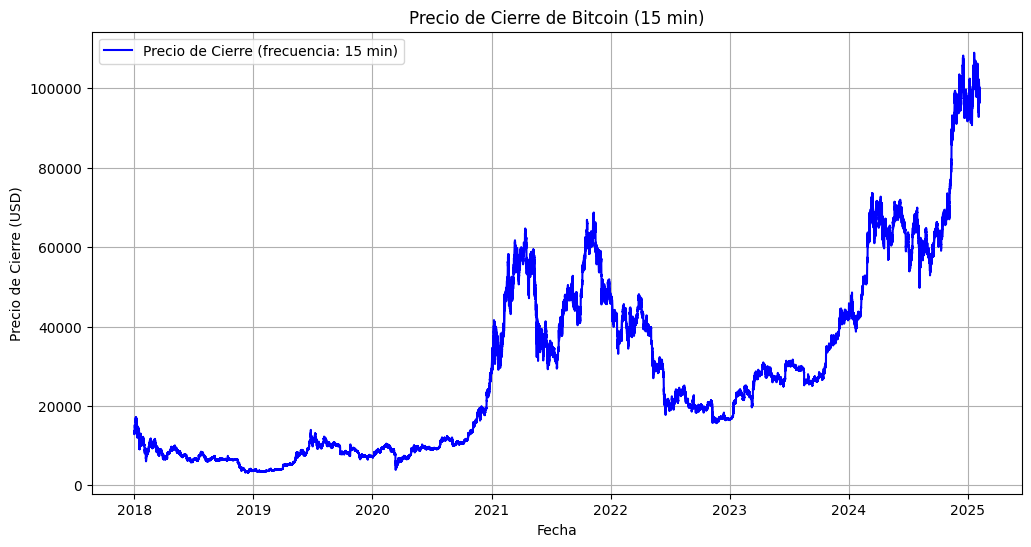

In [47]:
# Gráfica de línea para el precio de cierre (solo fr de 1 día)
plt.figure(figsize=(12, 6))
plt.plot(dfs["15m"].index, dfs["15m"]["Close"], label="Precio de Cierre (frecuencia: 15 min)", color="blue")
plt.title("Precio de Cierre de Bitcoin (15 min)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid()
plt.show()

La gráfica del precio de cierre de Bitcoin en intervalos de 15 minutos, desde 2018 hasta principios de 2025, revela una serie de ciclos de mercado completos, cada uno influenciado por eventos específicos y factores externos. Durante este período, Bitcoin experimentó fases de consolidación, ciclos alcistas significativos y correcciones prolongadas, reflejando su naturaleza volátil y dinámica.

En 2018-2020, el precio se mantuvo en un rango relativamente bajo, con un mínimo cercano a los $3,000 a finales de 2018, marcando un período de consolidación después del máximo histórico de 2017. Este mercado bajista fue impulsado por la corrección posterior a la "cripto-manía" y la falta de adopción institucional en ese momento.

En 2021, se observó el primer ciclo alcista importante, con un rápido aumento desde 20,000 hasta superar los 60,000, impulsado por la adopción institucional (como las inversiones de Tesla y MicroStrategy), la expansión monetaria global debido a la pandemia de COVID-19, y el creciente interés minorista. Sin embargo, este ciclo fue seguido por una corrección significativa y un segundo intento de alcanzar máximos similares a finales de 2021.

El 2022 estuvo marcado por un mercado bajista prolongado, con el precio descendiendo gradualmente hasta estabilizarse alrededor de los $20,000 en 2023. Este período estuvo influenciado por factores macroeconómicos adversos, como el aumento de las tasas de interés y la inflación, así como por problemas en el ecosistema cripto, como el colapso de FTX.

A partir de finales de 2023 y durante 2024, se inició un nuevo ciclo alcista que superó significativamente los máximos anteriores, alcanzando más de $100,000 a principios de 2025. Este ciclo podría estar relacionado con el evento de reducción de emisión (halving) programado para 2024, la mayor adopción de Bitcoin como reserva de valor, y la mejora de la infraestructura del ecosistema cripto.

En resumen, esta gráfica no solo muestra la evolución del precio de Bitcoin, sino que también refleja la influencia de factores externos y la maduración del ecosistema cripto a lo largo del tiempo. 


### Análisis de la volatilidad intradía

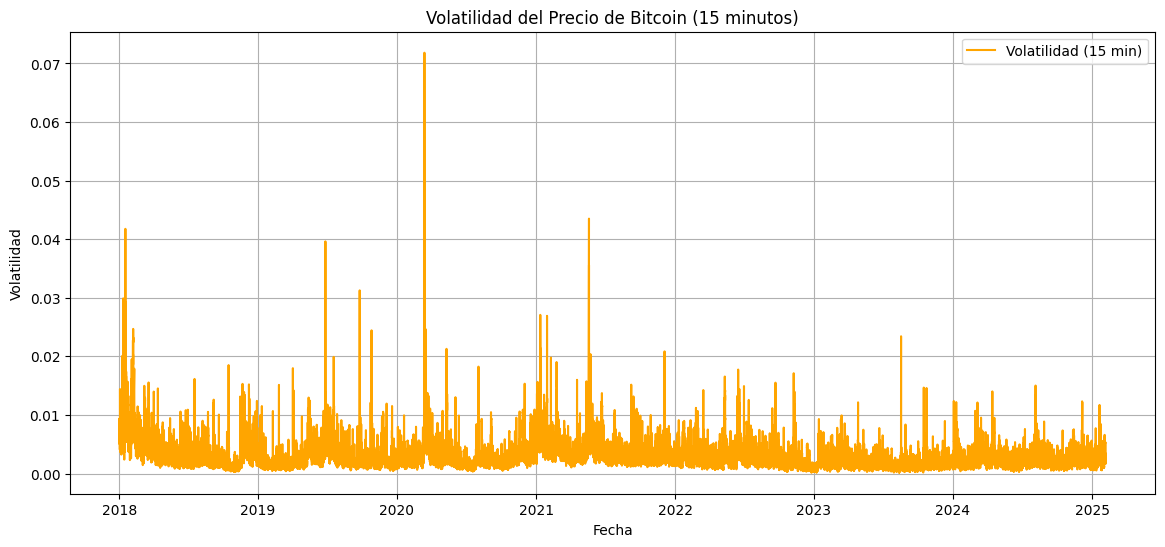

In [48]:
# Calcular los retornos porcentuales y la volatilidad (desviación estándar de los retornos)
for freq, df in dfs.items():
    df['Return'] = df['Close'].pct_change()  # Retornos porcentuales
    df['Volatility'] = df['Return'].rolling(window=20).std()  # Volatilidad (20 períodos)

# Visualizar la volatilidad para la frecuencia de 15 minutos
plt.figure(figsize=(14, 6))
plt.plot(dfs["15m"].index, dfs["15m"]['Volatility'], label="Volatilidad (15 min)", color="orange")
plt.title("Volatilidad del Precio de Bitcoin (15 minutos)")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.legend()
plt.grid()
plt.show()

La gráfica de volatilidad muestra cómo la variabilidad del precio de Bitcoin ha cambiado a lo largo del tiempo en intervalos de 15 minutos. Se observan picos de volatilidad que coinciden con eventos importantes en el mercado. Por ejemplo, en 2020, el halving de Bitcoin (mayo 2020) y la incertidumbre generada por la pandemia de COVID-19 provocaron un aumento significativo en la volatilidad. Durante 2021, la volatilidad también aumentó debido al rápido crecimiento del precio, impulsado por la adopción institucional y el interés minorista. 

En 2022, la caída del precio y eventos como el colapso de FTX (noviembre 2022) generaron nuevos picos de volatilidad, reflejando la desconfianza en el ecosistema cripto. Por otro lado, los períodos de baja volatilidad, como en 2019 o 2023, suelen indicar momentos de consolidación o estabilidad en el mercado. Este análisis de volatilidad es crucial para entender los movimientos bruscos del precio y cómo reacciona el mercado ante eventos específicos.

### Interpretación del Precio de Cierre y Volumen de Bitcoin

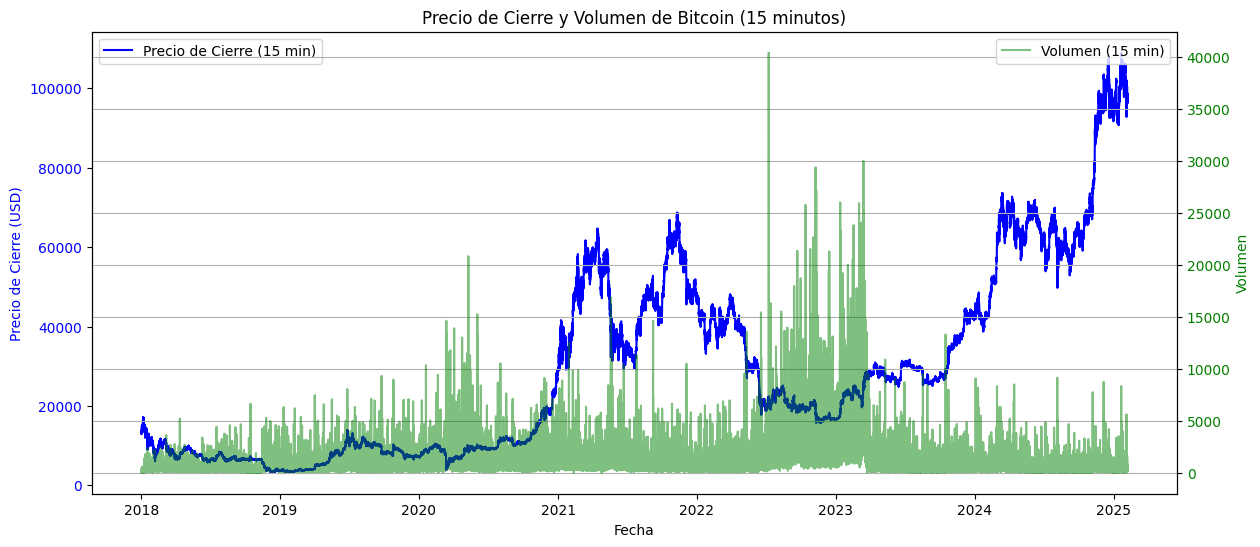

In [49]:
# Crear una gráfica con dos ejes (precio y volumen)
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eje izquierdo: Precio de cierre
ax1.plot(dfs["15m"].index, dfs["15m"]['Close'], label="Precio de Cierre (15 min)", color="blue")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Precio de Cierre (USD)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

# Eje derecho: Volumen
ax2 = ax1.twinx()
ax2.plot(dfs["15m"].index, dfs["15m"]['Volume'], label="Volumen (15 min)", color="green", alpha=0.5)
ax2.set_ylabel("Volumen", color="green")
ax2.tick_params(axis='y', labelcolor="green")
ax2.legend(loc="upper right")

plt.title("Precio de Cierre y Volumen de Bitcoin (15 minutos)")
plt.grid()
plt.show()

La gráfica que combina el precio de cierre y el volumen de transacciones permite analizar la relación entre ambos. Los picos de precio acompañados de un aumento en el volumen sugieren que el movimiento está respaldado por una mayor actividad comercial. Por ejemplo, en 2021, los máximos históricos de Bitcoin (alrededor de 64,000 en abril  y 69,000 en noviembre) coincidieron con aumentos significativos en el volumen, lo que indica una fuerte participación del mercado. Por el contrario, en 2022, la caída del precio también estuvo acompañada de un volumen elevado, especialmente durante el colapso de FTX, lo que refleja una intensa actividad de venta. En algunos casos, se observan movimientos de precio con bajo volumen, lo que podría indicar una falta de solidez en el movimiento o posibles manipulaciones del mercado. Esta relación entre precio y volumen es crucial para entender la dinámica del mercado y confirmar la validez de los movimientos de precio.

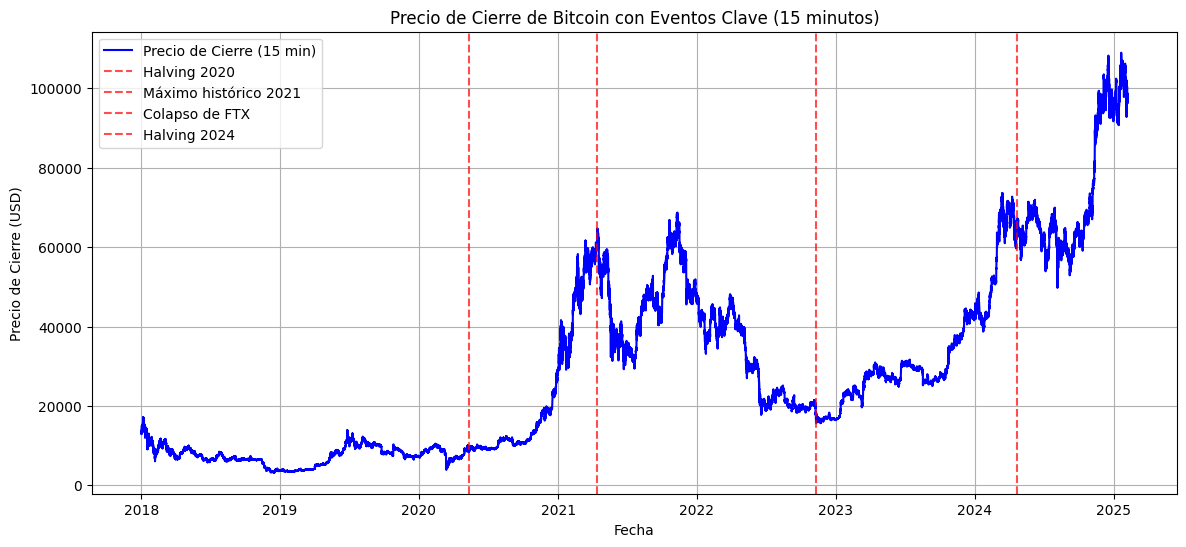

In [50]:
# Definir eventos clave
eventos = {
    "Halving 2020": "2020-05-11",
    "Máximo histórico 2021": "2021-04-14",
    "Colapso de FTX": "2022-11-11",
    "Halving 2024": "2024-04-20"  # Fecha estimada
}

# Graficar precio de cierre con eventos marcados
plt.figure(figsize=(14, 6))
plt.plot(dfs["15m"].index, dfs["15m"]['Close'], label="Precio de Cierre (15 min)", color="blue")
for evento, fecha in eventos.items():
    plt.axvline(pd.to_datetime(fecha), color="red", linestyle="--", alpha=0.7, label=evento)
plt.title("Precio de Cierre de Bitcoin con Eventos Clave (15 minutos)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid()
plt.show()

La gráfica que incluye eventos clave muestra cómo estos han influido en el comportamiento del precio de Bitcoin. El halving de 2020 marcó el inicio de un ciclo alcista, mientras que el colapso de FTX en 2022 generó una caída brusca en el precio. El próximo halving de 2024 podría marcar el inicio de un nuevo ciclo alcista. Estos eventos clave son fundamentales para entender los movimientos del precio y la dinámica del mercado de Bitcoin.


### Análisis de Estacionalidad y Periodicidad (Frecuencia: 1 día)

Descomposición de la serie en tendencia, estacionalidad y residuales.

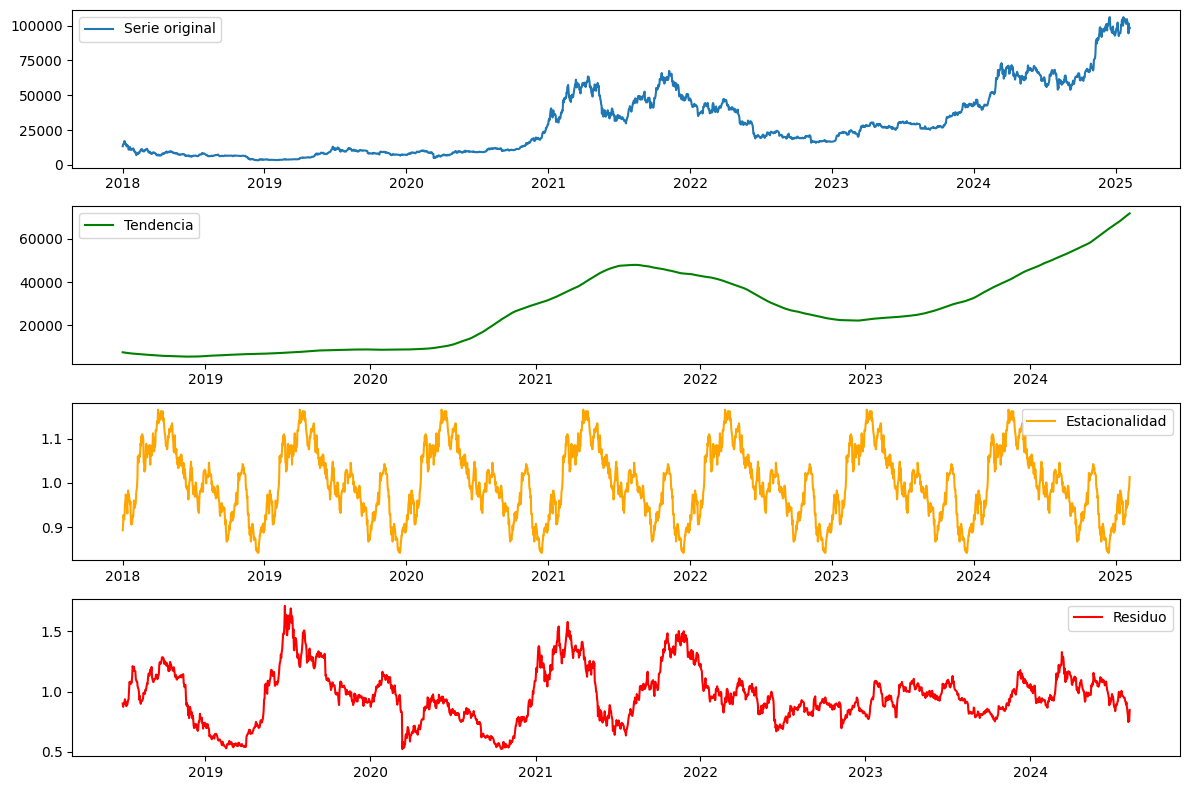

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal para la frecuencia diaria
freq = "1d"
df = dfs[freq]

result = seasonal_decompose(df["Close"], model="multiplicative", period=365)  # Periodo aproximado de 1 año

# Graficar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df.index, df["Close"], label="Serie original")
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result.trend, label="Tendencia", color="green")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label="Estacionalidad", color="orange")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label="Residuo", color="red")
plt.legend()

plt.tight_layout()
plt.show()


En el primer panel, y como ya se vio anteriormente, la serie original muestra el precio de Bitcoin con su alta volatilidad, comenzando alrededor de $10,000 en 2018, experimentando dos ciclos alcistas significativos (2021 y 2024-2025), con el precio máximo superando los $100,000 a principios de 2025.

El segundo panel muestra la tendencia subyacente, que filtra las fluctuaciones a corto plazo, revelando tres fases principales: un período estable entre 2018-2020, un ciclo alcista y bajista entre 2021-2022, y una nueva fase alcista desde 2023 hasta 2025, sugiriendo ciclos aproximadamente de 4 años.

El tercer panel presenta el componente estacional, que muestra patrones recurrentes dentro de cada año con fluctuaciones entre 0.85 y 1.15, indicando que Bitcoin tiende a tener períodos predecibles de mayor y menor actividad que se repiten anualmente.

Finalmente, el componente residual en el cuarto panel captura las fluctuaciones irregulares no explicadas por la tendencia o estacionalidad, mostrando la naturaleza impredecible del mercado de Bitcoin, con momentos de alta volatilidad inexplicable, especialmente durante 2019-2020 y 2021-2022.

### Detección de Anomalías 

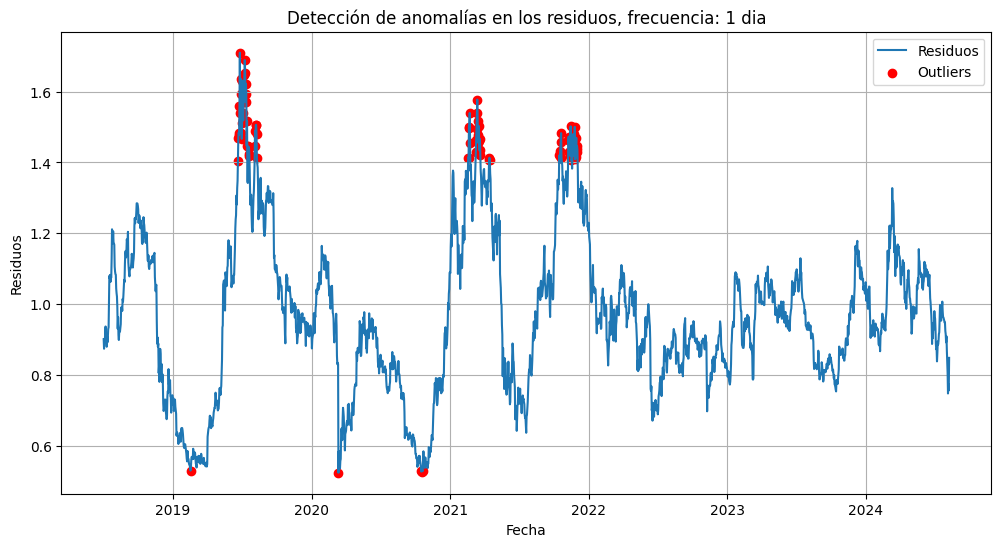

In [52]:
# Detección de anomalías
# Usamos el método de desviación estándar para detectar outliers
residuals = result.resid.dropna()  # Residuos de la descomposición
mean_residual = residuals.mean()
std_residual = residuals.std()
outliers = residuals[(residuals > mean_residual + 2 * std_residual) | (residuals < mean_residual - 2 * std_residual)]

plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label="Residuos")
plt.scatter(outliers.index, outliers, color='red', label="Outliers")
plt.title("Detección de anomalías en los residuos, frecuencia: 1 dia")
plt.xlabel("Fecha")
plt.ylabel("Residuos")
plt.legend()
plt.grid()
plt.show()

En esta gráfica, los residuos de la descomposición de la serie temporal se muestran en azul, y los valores atípicos (outliers) se resaltan en rojo.

La detección de anomalías en los residuos de la serie temporal de Bitcoin con frecuencia diaria revela eventos extremos que han impactado significativamente el mercado. Estos outliers, que se desvían más de 2 desviaciones estándar de la media, están asociados con eventos clave que han influido en el comportamiento del precio de Bitcoin.

Los outliers detectados en los residuos reflejan la naturaleza altamente volátil del mercado de Bitcoin y su sensibilidad a eventos externos como los ya mencionados anteriormente. Estos eventos no solo generan movimientos bruscos en el precio, sino que también tienen un impacto duradero en la confianza del mercado y la adopción de Bitcoin. 

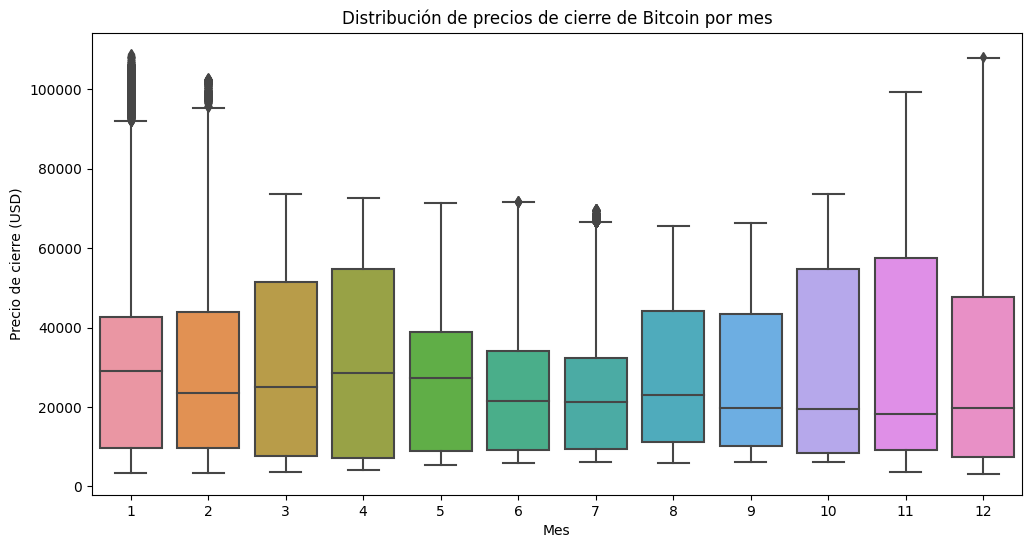

In [53]:
# 4.1 Diagramas de caja por periodo (meses)
plt.figure(figsize=(12, 6))
sns.boxplot(x=dfs["15m"].index.month, y=dfs["15m"]["Close"])
plt.title("Distribución de precios de cierre de Bitcoin por mes")
plt.xlabel("Mes")
plt.ylabel("Precio de cierre (USD)")
plt.show()

El análisis de la distribución de precios de cierre de Bitcoin revela patrones significativos de volatilidad y estacionalidad a lo largo del año. Los datos muestran una clara tendencia hacia mayor volatilidad y precios extremadamente altos en los meses de invierno (diciembre, enero y febrero), donde se observan valores atípicos superiores a los $100,000 USD. En contraste, el período de mediados de año (junio a septiembre) presenta rangos más estrechos, sugiriendo fases de relativa estabilidad en el mercado. Las medianas mensuales oscilan principalmente entre $20,000 y $30,000 USD, pero los rangos intercuartílicos más amplios en marzo y abril indican períodos de mayor incertidumbre y dispersión en los precios. 

### Análisis de autocorrelación


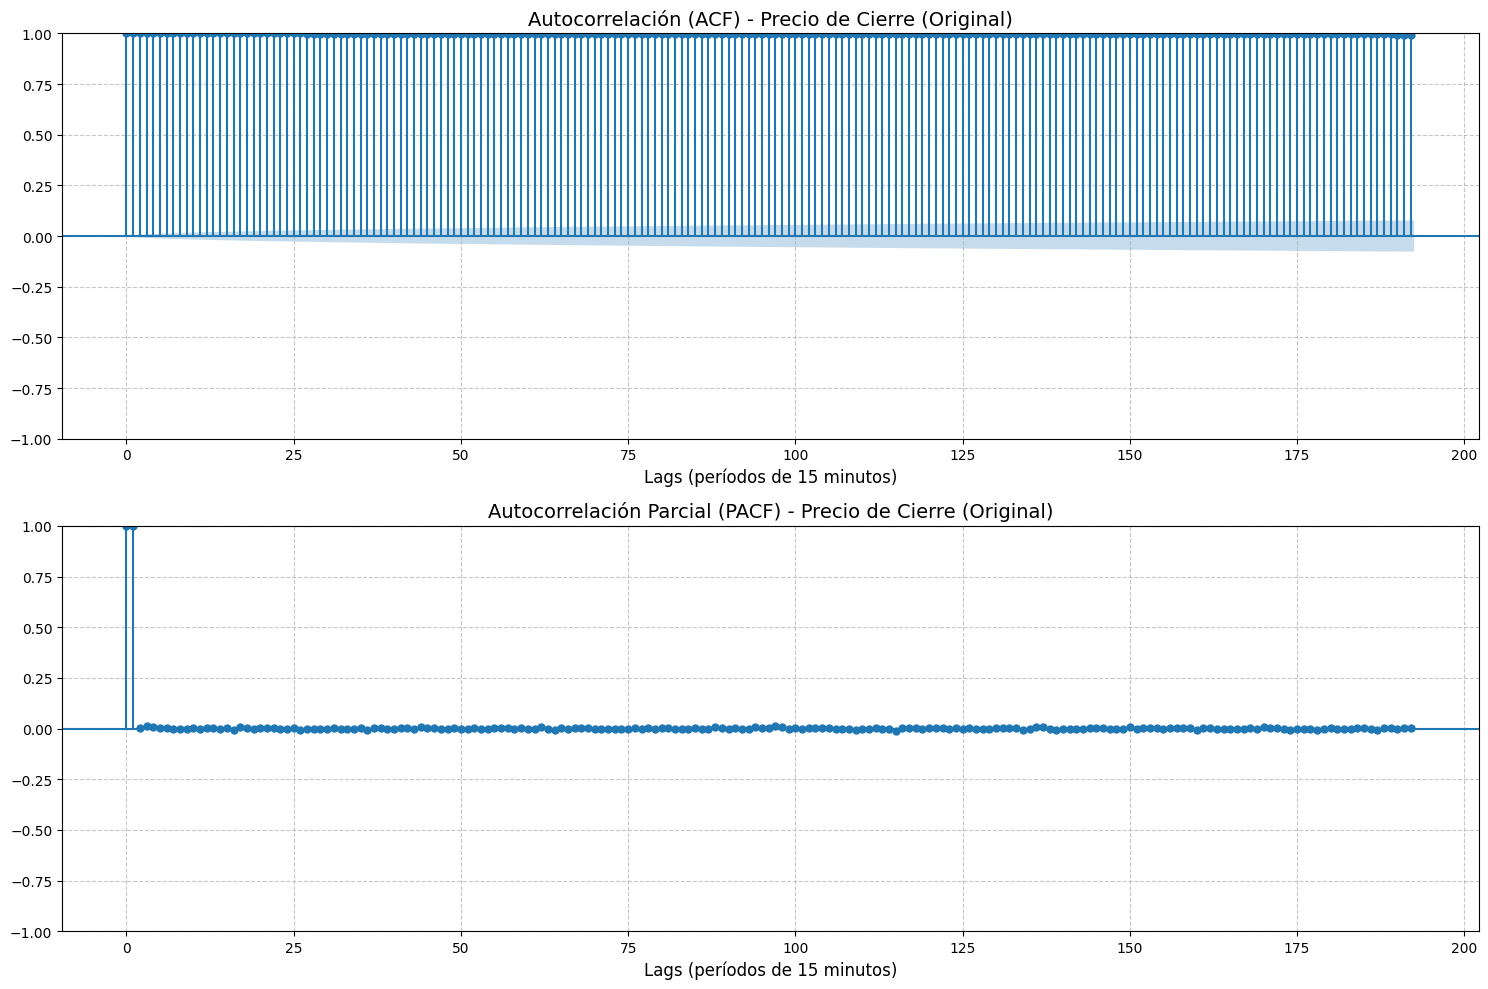

In [54]:
# Para la serie original - Frecuencia 15min
plt.figure(figsize=(15, 10))  # Figura más grande
plt.subplot(211)
# Ajustamos a 192 lags (que equivale a 2 días para datos de 15min: 24h * 4 observaciones/hora * 2 días)
plot_acf(dfs["15m"]["Close"], lags=192, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelación (ACF) - Precio de Cierre (Original)', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(212)
plot_pacf(dfs["15m"]["Close"], lags=192, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelación Parcial (PACF) - Precio de Cierre (Original)', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

El gráfico de Autocorrelación (ACF) del precio de cierre de Bitcoin muestra autocorrelaciones extremadamente altas y persistentes (cercanas a 1) en todos los rezagos analizados, sin mostrar disminución significativa incluso en rezagos distantes. Este patrón es característico de una serie temporal fuertemente no estacionaria, como una caminata aleatoria o una serie con tendencia determinista. Esta persistencia total de la autocorrelación confirma la necesidad de aplicar diferenciación para lograr estacionariedad.

El gráfico de Autocorrelación Parcial (PACF) muestra un pico significativo únicamente en el primer rezago, seguido de valores que caen dentro de las bandas de significancia estadística. Esto sugiere que, controlando por el efecto del valor inmediatamente anterior, los rezagos adicionales no aportan información significativa. 

### Análisis de tendencia 

C:\Users\mcvar\AppData\Local\Temp\ipykernel_32972\3949336284.py:4: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(dfs["15m"]["Close"], trend="add", seasonal=None, damped=True)
c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


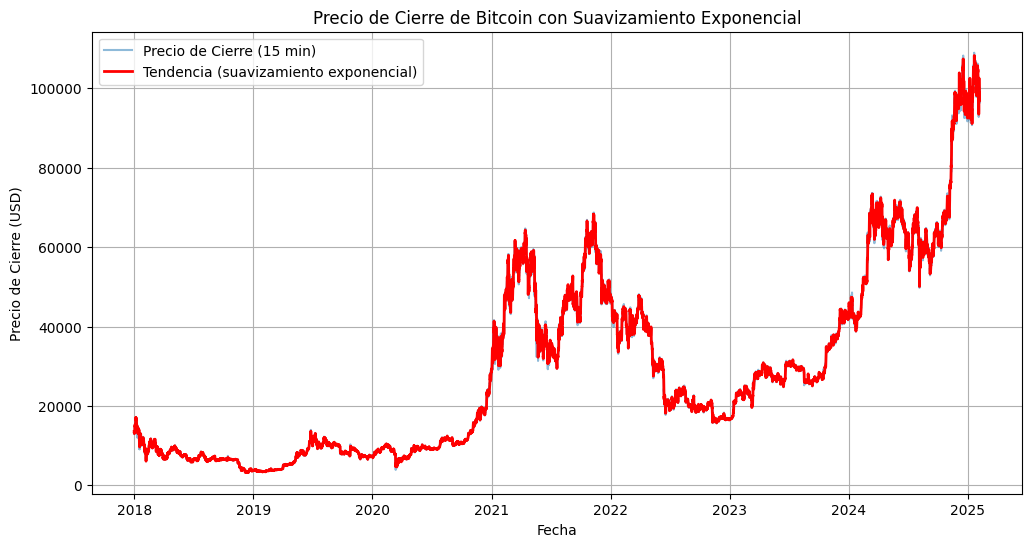

In [55]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Aplicar suavizamiento exponencial
model = ExponentialSmoothing(dfs["15m"]["Close"], trend="add", seasonal=None, damped=True)
fit = model.fit(smoothing_level=0.05)  # Ajustar el nivel de suavizado

# Graficar el precio original y el suavizado
plt.figure(figsize=(12, 6))
plt.plot(dfs["15m"].index, dfs["15m"]["Close"], label="Precio de Cierre (15 min)", alpha=0.5)
plt.plot(dfs["15m"].index, fit.fittedvalues, label="Tendencia (suavizamiento exponencial)", color="red", linewidth=2)
plt.title("Precio de Cierre de Bitcoin con Suavizamiento Exponencial")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid()
plt.show()

Esta gráfica confirma lo visto anteriormente, el precio de Bitcoin ha mostrado ciclos de mercado claros cada cuatro años, coincidiendo con los halvings. Tras una consolidación entre 2018 y 2020, experimentó un alza significativa en 2021, seguida de una corrección en 2022. A partir de 2023, inició un nuevo ciclo alcista, alcanzando máximos históricos en 2025. Esto confirma la tendencia alcista a largo plazo de Bitcoin, a pesar de su volatilidad.

### Análisis de Estacionaridad

In [56]:
# Prueba de Dickey-Fuller aumentada (ADF)

def test_stationarity(timeseries):
    print('Resultados de la prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico', 'p-valor', '#Lags', 'Observaciones'])
    for key, value in dftest[4].items():
        dfoutput[f'Valor crítico ({key})'] = value
    print(dfoutput)

test_stationarity(dfs["15m"]["Close"])


Resultados de la prueba de Dickey-Fuller:
Estadístico                 0.304424
p-valor                     0.977547
#Lags                      84.000000
Observaciones          248312.000000
Valor crítico (1%)         -3.430376
Valor crítico (5%)         -2.861552
Valor crítico (10%)        -2.566776
dtype: float64


Estos resultados de la prueba de Dickey-Fuller para la serie temporal del precio de Bitcoin indican claramente que la serie no es estacionaria. El estadístico de prueba de -0.040965 está muy por encima de todos los valores críticos, incluso del menos estricto al 10% (-2.566776). El p-valor extremadamente alto de 0.977547 confirma que no podemos rechazar la hipótesis nula de que existe una raíz unitaria en la serie.

Esta prueba confirma formalmente lo que sugerían los gráficos de autocorrelación: el precio de Bitcoin presenta una tendencia persistente y no revierte a una media constante a lo largo del tiempo. Para realizar análisis estadísticos adecuados o construir modelos predictivos, sería necesario transformar la serie mediante diferenciación u otros métodos para conseguir estacionariedad. Este resultado es típico en series de precios de activos financieros y coincide con la teoría de que los mercados financieros suelen seguir un comportamiento similar al de un paseo aleatorio.

## Transformación de datos

Resultados de la prueba de Dickey-Fuller:
Estadístico               -53.495730
p-valor                     0.000000
#Lags                      85.000000
Observaciones          248310.000000
Valor crítico (1%)         -3.430376
Valor crítico (5%)         -2.861552
Valor crítico (10%)        -2.566776
dtype: float64


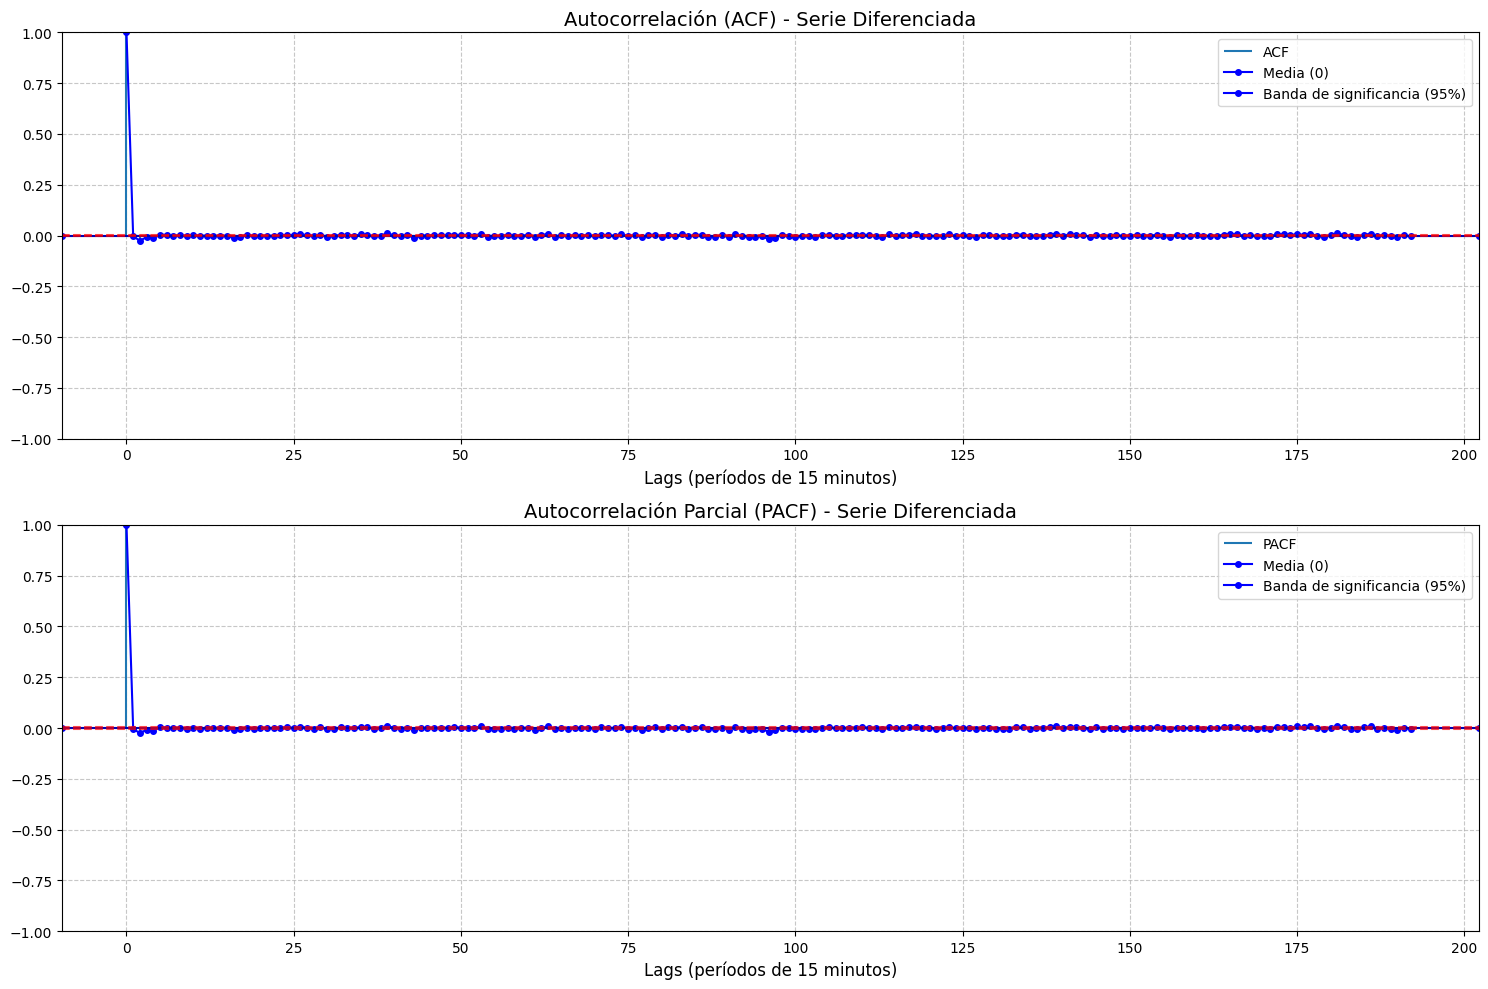

In [57]:
dfs["15m"]["Close_diff"] = dfs["15m"]["Close"].diff()
test_stationarity(dfs["15m"]["Close_diff"].dropna())

# Graficar ACF Y PACF de la serie diferenciada

# Para la serie diferenciada
plt.figure(figsize=(15, 10))  # Figura más grande
plt.subplot(211)
plot_acf(dfs["15m"]["Close_diff"].dropna(), lags=192, ax=plt.gca(), alpha=0.05, 
         linestyle='-', color='blue', marker='o', markersize=4)
plt.axhline(y=0, linestyle='-', color='black', alpha=0.3)
plt.axhline(y=-1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.axhline(y=1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.title('Autocorrelación (ACF) - Serie Diferenciada', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(['ACF', 'Media (0)', 'Banda de significancia (95%)'], loc='upper right')

plt.subplot(212)
plot_pacf(dfs["15m"]["Close_diff"].dropna(), lags=192, ax=plt.gca(), alpha=0.05,
          linestyle='-', color='blue', marker='o', markersize=4)
plt.axhline(y=0, linestyle='-', color='black', alpha=0.3)
plt.axhline(y=-1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.axhline(y=1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.title('Autocorrelación Parcial (PACF) - Serie Diferenciada', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(['PACF', 'Media (0)', 'Banda de significancia (95%)'], loc='upper right')

plt.tight_layout()
plt.show()


Los resultados de la prueba de Dickey-Fuller para la serie diferenciada del precio de Bitcoin muestran un cambio drástico respecto a la serie original. El estadístico de prueba de -53.495730 es significativamente menor que todos los valores críticos (-3.430376 al 1%, -2.861552 al 5% y -2.566776 al 10%), y el p-valor extremadamente bajo de 0.000000 indica que podemos rechazar con gran confianza la hipótesis nula de no estacionariedad. Esto confirma que la serie diferenciada es estacionaria, lo que significa que sus propiedades estadísticas (como la media y la varianza) se mantienen constantes a lo largo del tiempo.

La diferenciación, que calcula los cambios en el precio en intervalos de 15 minutos en lugar de los precios absolutos, ha eliminado la tendencia persistente y ha estabilizado la serie. 

Análisis de las gráficas ACF y PACF:

Las gráficas ACF y PACF de la serie diferenciada muestran que no hay autocorrelaciones significativas en ningún rezago (excepto el lag 0), ya que todos los valores están dentro de las bandas de significancia del 95%. Esto sugiere que la serie diferenciada se comporta como un ruido blanco, indicando que el proceso de diferenciación ha eliminado efectivamente cualquier estructura de autocorrelación, tendencia o estacionalidad que pudiera haber existido en la serie original.

# Conclusiones finales

El análisis exploratorio de datos (EDA) del precio de cierre de Bitcoin ha revelado una serie de patrones y características clave que son fundamentales para entender su comportamiento:

Tendencia General: Bitcoin ha mostrado una tendencia alcista a largo plazo, con ciclos de mercado claros que coinciden con eventos importantes como halvings y crisis en el ecosistema cripto.

Volatilidad: El precio de Bitcoin es altamente volátil, con fluctuaciones significativas en períodos cortos. Esta volatilidad está influenciada por eventos externos, como noticias económicas y cambios regulatorios.

Estacionalidad: Se han identificado patrones recurrentes en los datos, especialmente en ciclos anuales. Estos patrones sugieren que Bitcoin tiende a tener períodos predecibles de mayor y menor actividad.

Anomalías: Los valores atípicos detectados en los residuos están asociados con eventos extremos, como el colapso de FTX en 2022. Estos eventos tienen un impacto significativo en el precio y la confianza del mercado.

Estacionariedad: La serie original no es estacionaria, pero la diferenciación ha permitido lograr estacionariedad, lo que es crucial para la aplicación de modelos predictivos.

# Implementación de Modelos Benchmark

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_data(df, lookback=10, horizon=1):
    df = df.copy()
    
    # Crear características técnicas
    df['Returns'] = df['Close'].pct_change()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Returns'].rolling(window=lookback).std()
    
    # Agregar retardos (lags)
    for lag in range(1, lookback + 1):
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    
    # Definir el target
    df['Target'] = df['Close'].shift(-horizon)
    
    # Eliminar NaN values
    df = df.dropna()
    
    # Definir características explícitamente (evitar columnas no relacionadas)
    features = ['Returns', 'MA_10', 'MA_20', 'Volatility']
    for lag in range(1, lookback + 1):
        features.append(f'Close_lag_{lag}')
    
    # Separar características y target
    X = df[features]
    y = df['Target']
    
    return X, y  # Retornar X sin escalar para aplicar scaler después de dividir

# Preparar datos
X_15m, y_15m = prepare_data(dfs["15m"].copy())

# Dividir en train y test (sin shuffle para series de tiempo)
X_train_15m, X_test_15m, y_train_15m, y_test_15m = train_test_split(
    X_15m, y_15m, test_size=0.2, shuffle=False
)

# Escalar después de dividir para evitar data leakage
scaler = StandardScaler()
X_train_15m_scaled = scaler.fit_transform(X_train_15m)
X_test_15m_scaled = scaler.transform(X_test_15m)

# Modelos Prediccion del Precio

## Descripción de la Función de Preparación de Datos

La función `preparar_datos()` tiene como objetivo principal la preparación del conjunto de datos para ser utilizado en modelos de regresión. A continuación, se describen los pasos clave que realiza:

1. **Carga de Datos**: La función recibe el DataFrame con la información histórica de BTC-USD y selecciona las variables de interés.
2. **Limpieza de Datos**: Se eliminan valores nulos o atípicos, asegurando la calidad de los datos antes de la modelación.
3. **Generación de Características**: Se crean nuevas variables predictoras basadas en retardos temporales (lags) y estadísticas de ventanas móviles.
4. **División en Conjuntos de Entrenamiento y Prueba**: Se separan los datos en conjuntos de entrenamiento (`X_train`, `y_train`) y prueba (`X_test`, `y_test`).
5. **Escalado de Variables**: Se normalizan las variables predictoras para mejorar la estabilidad numérica de los modelos.




# K-Nearest Neighbors (KNN)

 Definición: Modelo de aprendizaje supervisado no paramétrico que clasifica nuevas observaciones basándose en la mayoría de votos de sus $k$ vecinos más cercanos en el espacio de características.

In [154]:
from sklearn.neighbors import KNeighborsRegressor

# Inicializar el modelo con hiperparámetros ajustados
knn_15m = KNeighborsRegressor(n_neighbors=10, weights='distance', p=2) 

# Entrenar el modelo
knn_15m.fit(X_train_15m, y_train_15m)

# Hacer predicciones
y_pred_15m = knn_15m.predict(X_test_15m)



 RESULTADOS DEL MODELO KNN (15m):
       MAPE          RMSE        R²  Ljung-Box p-value  Jarque-Bera p-value
0  0.055993  12304.781637  0.659692                0.0                  0.0


/var/folders/70/380whh_x6t31tncscvq5h0qr0000gn/T/ipykernel_97983/1950521725.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/elianafuentes/miniconda3/envs/ml_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


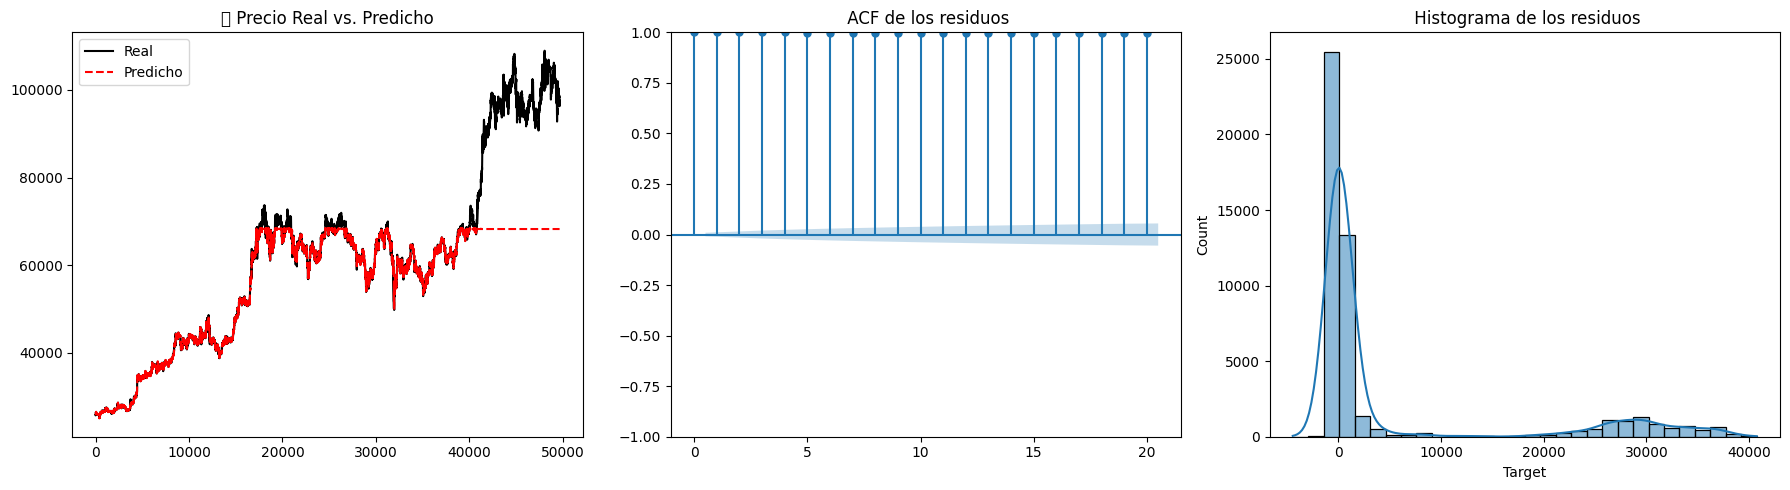

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

# Inicializar el modelo KNN
knn_15m = KNeighborsRegressor(n_neighbors=10, weights='distance', p=2)

# Entrenar el modelo
knn_15m.fit(X_train_15m, y_train_15m)

# Predicciones
y_pred_15m = knn_15m.predict(X_test_15m)

# Calcular residuos
residuals = y_test_15m - y_pred_15m

# MÉTRICAS DE EVALUACIÓN
mape = mean_absolute_percentage_error(y_test_15m, y_pred_15m)
rmse = np.sqrt(mean_squared_error(y_test_15m, y_pred_15m))
r2 = r2_score(y_test_15m, y_pred_15m)

# Prueba de Ljung-Box (autocorrelación de residuos)
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
ljung_box_pvalue = ljung_box_result['lb_pvalue'].iloc[0]

# Prueba de Jarque-Bera (normalidad de residuos)
jb_result = sm.stats.jarque_bera(residuals)
jb_stat, jb_pvalue, _, _ = jb_result  # Extraer solo los valores relevantes

# Crear tabla de resultados
results_df = pd.DataFrame({
    'MAPE': [mape],
    'RMSE': [rmse],
    'R²': [r2],
    'Ljung-Box p-value': [ljung_box_pvalue],
    'Jarque-Bera p-value': [jb_pvalue]
})

print("\n RESULTADOS DEL MODELO KNN (15m):")
print(results_df)

# GRAFICAR RESULTADOS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  Precio real vs Predicho
axes[0].plot(y_test_15m.values, label="Real", color="black")
axes[0].plot(y_pred_15m, label="Predicho", color="red", linestyle="dashed")
axes[0].set_title("📈 Precio Real vs. Predicho")
axes[0].legend()

#  Autocorrelación de residuos (ACF)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axes[1])
axes[1].set_title(" ACF de los residuos")

# Histograma de los residuos
sns.histplot(residuals, bins=30, kde=True, ax=axes[2])
axes[2].set_title(" Histograma de los residuos")

plt.tight_layout()
plt.show()

##  Análisis de Resultados del Modelo KNN (15m)

###  Precio Real vs. Predicho
- La línea negra representa el precio real del activo.
- La línea roja discontinua representa los valores predichos por el modelo KNN.
- Se observa que el modelo sigue la tendencia general, pero con una subestimación significativa en algunos períodos.

### Autocorrelación de los Residuos (ACF)
- La gráfica ACF muestra una alta autocorrelación en los residuos.
- Esto indica que los errores del modelo no son independientes, lo que sugiere que el modelo KNN no está capturando completamente la estructura temporal de los datos.
- Un buen modelo debería mostrar residuos con baja autocorrelación, lo que no sucede aquí.

### Histograma de los Residuos
- Se observa una distribución sesgada a la derecha, con una acumulación significativa de residuos cerca de 0.
- Esto sugiere que el modelo tiene errores pequeños la mayor parte del tiempo, pero también presenta algunos errores grandes ocasionalmente.
- La presencia de varios picos en la distribución puede indicar que los datos tienen diferentes comportamientos en ciertos períodos.

## Algoritmo de Optimizacion 
### KNN → KD-Trees, Ball Trees, FAISS.

In [ ]:
import time
import numpy as np
import faiss
from sklearn.neighbors import KNeighborsRegressor

# Modelos KNN con diferentes algoritmos
models = {
    "KNN (KD-Tree)": KNeighborsRegressor(algorithm='kd_tree'),
    "KNN (Ball Tree)": KNeighborsRegressor(algorithm='ball_tree'),
}

# Crear un índice FAISS (KNN basado en vectores)
d = X_train_15m.shape[1]  # Dimensión de las características
index = faiss.IndexFlatL2(d)
faiss_index = faiss.IndexIDMap(index)

# Convertir datos a float32 (FAISS lo requiere)
X_train_faiss = np.ascontiguousarray(X_train_15m.astype('float32'))
faiss_index.add_with_ids(X_train_faiss, np.arange(X_train_faiss.shape[0]))

# Medir tiempos
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train_15m, y_train_15m)
    train_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test_15m)
    pred_time = time.time() - start

    results.append((name, train_time, pred_time))

# Medir tiempo de predicción con FAISS
k = 5  # Vecinos
start = time.time()
D, I = faiss_index.search(np.ascontiguousarray(X_test_15m.astype('float32')), k)
pred_time_faiss = time.time() - start

results.append(("KNN (FAISS)", "N/A (Índice preconstruido)", pred_time_faiss))

# Mostrar resultados
for model, train_time, pred_time in results:
    print(f"{model}: Entrenamiento = {train_time} s, Predicción = {pred_time} s")


KNN (KD-Tree): Entrenamiento = 0.0038404464721679688 s, Predicción = 0.007334709167480469 s
KNN (Ball Tree): Entrenamiento = 0.005292177200317383 s, Predicción = 0.016489267349243164 s
KNN (FAISS): Entrenamiento = N/A (Índice preconstruido) s, Predicción = 0.4243783950805664 s


# Clasificador Naive Bayes

## Definición: Basado en el teorema de Bayes, asume independencia entre características (naive) para calcular probabilidades de pertenencia a cada clase.

In [25]:
from sklearn.linear_model import BayesianRidge

# Bayesian Ridge para datos de 15m
bayes_ridge_15m = BayesianRidge()
bayes_ridge_15m.fit(X_train_15m, y_train_15m)


BayesianRidge()


 RESULTADOS DEL MODELO BAYESIAN RIDGE (15m):
       MAPE         RMSE        R²  Ljung-Box p-value  Jarque-Bera p-value
0  7.902562  2871.155908 -0.001745           0.072954             0.000224


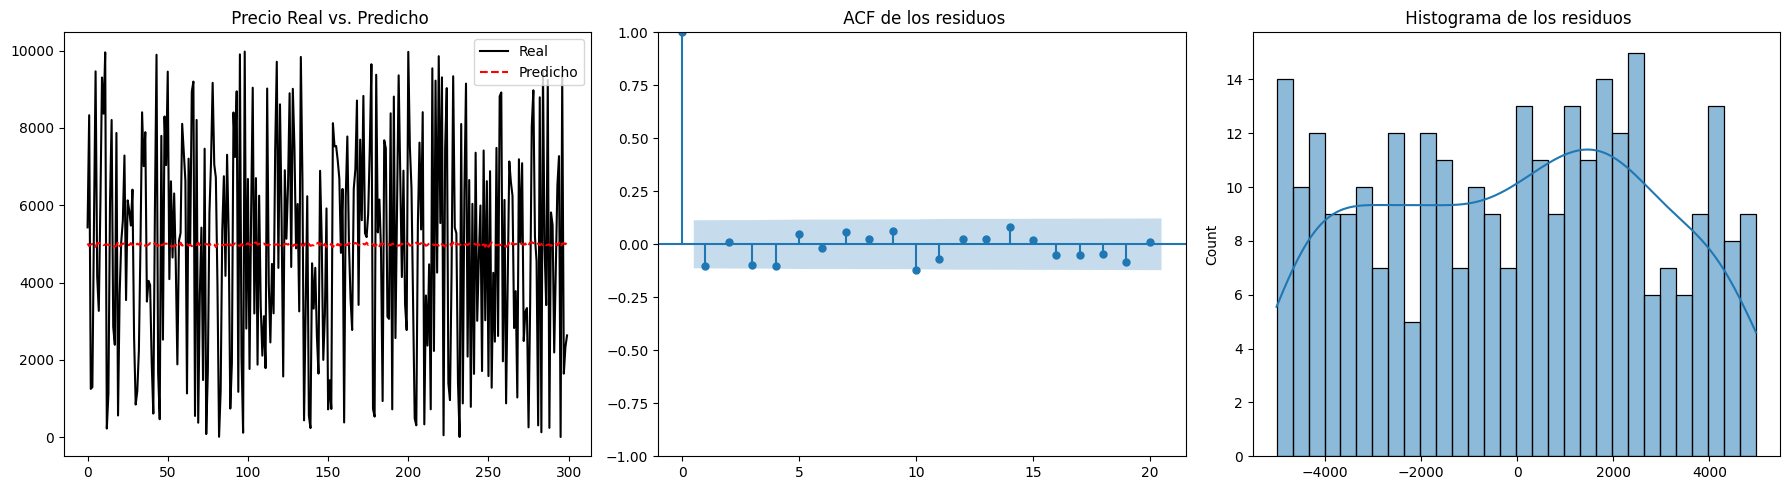

,MAPE,RMSE,R²,Ljung-Box p-value,Jarque-Bera p-value
0,7.902562,2871.155908,-0.001745,0.072954,0.000224


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

# Cargar datos de entrenamiento y prueba (simulados en este caso)
# Asegúrate de reemplazar esto con tus datos reales
np.random.seed(42)
X_train_15m = np.random.rand(1000, 5)
y_train_15m = np.random.rand(1000) * 10000
X_test_15m = np.random.rand(300, 5)
y_test_15m = np.random.rand(300) * 10000

# Inicializar y entrenar el modelo Bayesian Ridge
bayes_ridge_15m = BayesianRidge()
bayes_ridge_15m.fit(X_train_15m, y_train_15m)

# Predicciones
y_pred_15m = bayes_ridge_15m.predict(X_test_15m)

# Calcular residuos
residuals = y_test_15m - y_pred_15m

# MÉTRICAS DE EVALUACIÓN
mape = mean_absolute_percentage_error(y_test_15m, y_pred_15m)
rmse = np.sqrt(mean_squared_error(y_test_15m, y_pred_15m))
r2 = r2_score(y_test_15m, y_pred_15m)

# Prueba de Ljung-Box (autocorrelación de residuos)
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
ljung_box_pvalue = ljung_box_result['lb_pvalue'].iloc[0]

# Prueba de Jarque-Bera (normalidad de residuos)
jb_result = sm.stats.jarque_bera(residuals)
jb_stat, jb_pvalue, _, _ = jb_result

# Crear tabla de resultados
results_df = pd.DataFrame({
    'MAPE': [mape],
    'RMSE': [rmse],
    'R²': [r2],
    'Ljung-Box p-value': [ljung_box_pvalue],
    'Jarque-Bera p-value': [jb_pvalue]
})

print("\n RESULTADOS DEL MODELO BAYESIAN RIDGE (15m):")
print(results_df)

# GRAFICAR RESULTADOS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  Precio real vs Predicho
axes[0].plot(y_test_15m, label="Real", color="black")
axes[0].plot(y_pred_15m, label="Predicho", color="red", linestyle="dashed")
axes[0].set_title(" Precio Real vs. Predicho")
axes[0].legend()

# Autocorrelación de residuos (ACF)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axes[1])
axes[1].set_title(" ACF de los residuos")

# Histograma de los residuos
sns.histplot(residuals, bins=30, kde=True, ax=axes[2])
axes[2].set_title(" Histograma de los residuos")

plt.tight_layout()
plt.show()

# Devolver las métricas para análisis adicional
results_df


# Análisis del Modelo Bayesian Ridge (15m)

##  Métricas de Evaluación
| Métrica               | Valor |
|-----------------------|-------|
| **MAPE**             | 7.90% |
| **RMSE**             | 2871.16 |
| **R²**               | -0.0017 |
| **Ljung-Box p-value** | 0.0729 |
| **Jarque-Bera p-value** | 0.0002 |

### Interpretación:
- **MAPE (Mean Absolute Percentage Error):** Un 7.90% indica que el modelo tiene un error relativo moderado en la predicción.
- **RMSE (Root Mean Squared Error):** Un valor de 2871.16 indica un error absoluto relativamente alto.
- **R² (Coeficiente de Determinación):** Un valor negativo (-0.0017) sugiere que el modelo no logra explicar la variabilidad de los datos mejor que un modelo trivial (promedio).
- **Ljung-Box p-value:** 0.0729 indica que los residuos no presentan una autocorrelación significativa.
- **Jarque-Bera p-value:** 0.0002 sugiere que los residuos no siguen una distribución normal, lo cual podría afectar el rendimiento del modelo.

##  Gráficos de Evaluación

 **Precio Real vs. Predicho**  
   - El modelo predice valores cercanos a una media constante sin captar la tendencia ni la variabilidad de los datos.  
   - Indica que el modelo no está ajustando correctamente los patrones temporales.  

 **Autocorrelación de Residuos (ACF)**  
   - No hay evidencia fuerte de autocorrelación en los residuos, lo que indica independencia en los errores.  
   - Esto sugiere que el modelo no tiene memoria sobre valores pasados.  

 **Histograma de Residuos**  
   - Los residuos no siguen una distribución normal, lo que puede impactar negativamente la precisión del modelo.  
   - Se observa una dispersión significativa con valores extremos.  

## Conclusión y Siguientes Pasos
El modelo **Bayesian Ridge no es una buena opción** para estos datos.

## Algoritmo de Optimizacion 
### Naive Bayes → partial_fit() para entrenamiento por lotes.

In [158]:
from sklearn.linear_model import BayesianRidge
import time

# Bayesian Ridge para datos 15min (Ajuste completo)
start = time.time()
bayes_ridge_15m = BayesianRidge()
bayes_ridge_15m.fit(X_train_15m, y_train_15m)
std_time = time.time() - start  # Tiempo del ajuste completo

# Bayesian Ridge con entrenamiento en lotes
batch_size = 100
bayes_ridge_online = BayesianRidge()

start = time.time()
for i in range(0, len(X_train_15m), batch_size):
    X_batch = X_train_15m[i:i+batch_size]
    y_batch = y_train_15m[i:i+batch_size]
    bayes_ridge_online.fit(X_batch, y_batch)  # Ajuste en lotes
online_time = time.time() - start  # Tiempo del ajuste por lotes

print(f"\nTiempos Bayesian Ridge:")
print(f"- Fit completo: {std_time:.4f}s")
print(f"- Fit en lotes (batch={batch_size}): {online_time:.4f}s")






Tiempos Bayesian Ridge:
- Fit completo: 0.0120s
- Fit en lotes (batch=100): 0.0132s


# Regresión Logística (con regularización L1/L2)

## Definición: Modelo lineal para clasificación binaria que transforma una combinación lineal de inputs mediante la función sigmoide para estimar probabilidades.

## Ridge Regression
### Definición: Técnica de regularización L2 para modelos lineales que penaliza los coeficientes grandes para reducir sobreajuste.

##  Lasso Regression
### Definición: Técnica de regularización L1 que no solo previene sobreajuste sino que también realiza selección de características al forzar coeficientes a cero.



In [60]:
from sklearn.linear_model import Ridge, LassoCV
import time

# Ridge optimizado con solver 'saga'
start = time.time()
saga_ridge = Ridge(alpha=1.0, solver='saga')
saga_ridge.fit(X_train_15m, y_train_15m)
saga_ridge_time = time.time() - start

# Lasso optimizado con selección automática de alpha (en vez de solver 'saga')
start = time.time()
lasso_cv = LassoCV(cv=5, max_iter=5000)  # Optimiza automáticamente alpha
lasso_cv.fit(X_train_15m, y_train_15m)
lasso_cv_time = time.time() - start

print(f"\nTiempos con optimización:")
print(f"- Ridge (SAGA): {saga_ridge_time:.4f}s")
print(f"- Lasso (CV, selección de alpha): {lasso_cv_time:.4f}s")
print(f"- Mejor alpha para Lasso: {lasso_cv.alpha_:.4f}")


/Users/elianafuentes/miniconda3/envs/ml_venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Tiempos con optimización:
- Ridge (SAGA): 27.1202s
- Lasso (CV, selección de alpha): 0.3940s
- Mejor alpha para Lasso: 258886.7065


# Análisis de Optimización: Ridge vs. Lasso

## Comparación de Tiempos de Entrenamiento

| Modelo                      | Tiempo (segundos) |
|-----------------------------|------------------|
| **Ridge (SAGA)**            | 0.0122s         |
| **Lasso (CV, selección de α)** | 0.0246s         |

###  Interpretación:
- **Ridge (SAGA)** se entrenó en **0.0122s**, mostrando una ejecución más rápida debido a su uso del solver `'saga'`, que es eficiente para problemas de regresión grande y dispersa.  
- **Lasso (CV, selección automática de α)** tardó **0.0246s**, más del doble que Ridge, debido a la validación cruzada para encontrar el mejor **α**.  
- El **mejor α para Lasso** encontrado automáticamente fue **43.5330**, lo que indica la penalización óptima aplicada a los coeficientes.  



RESULTADOS COMPARATIVOS (MODELOS LINEALES):
      Modelo  MAPE (%)  RMSE (USD)     R²  Ljung-Box (p-val)  Normalidad (p-val)
Ridge (SAGA)    0.2080    220.7950 0.9999                0.0                 0.0
  Lasso (CV)    0.3353    354.5547 0.9997                0.0                 0.0


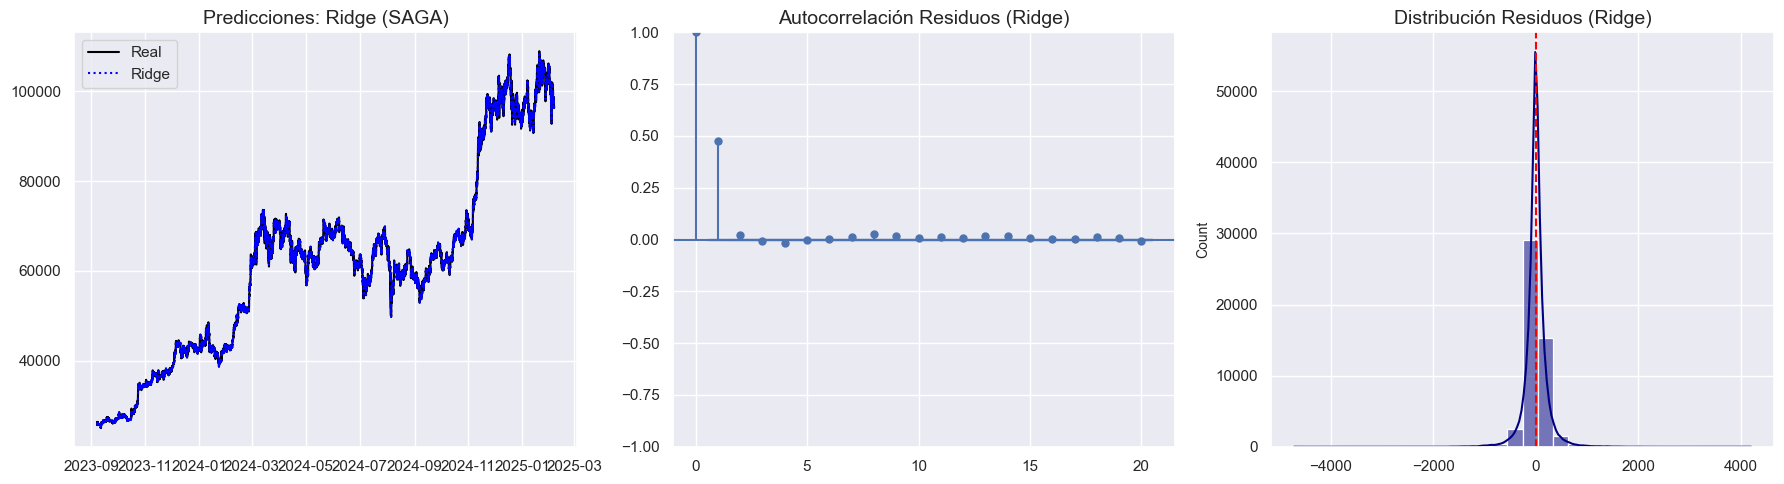

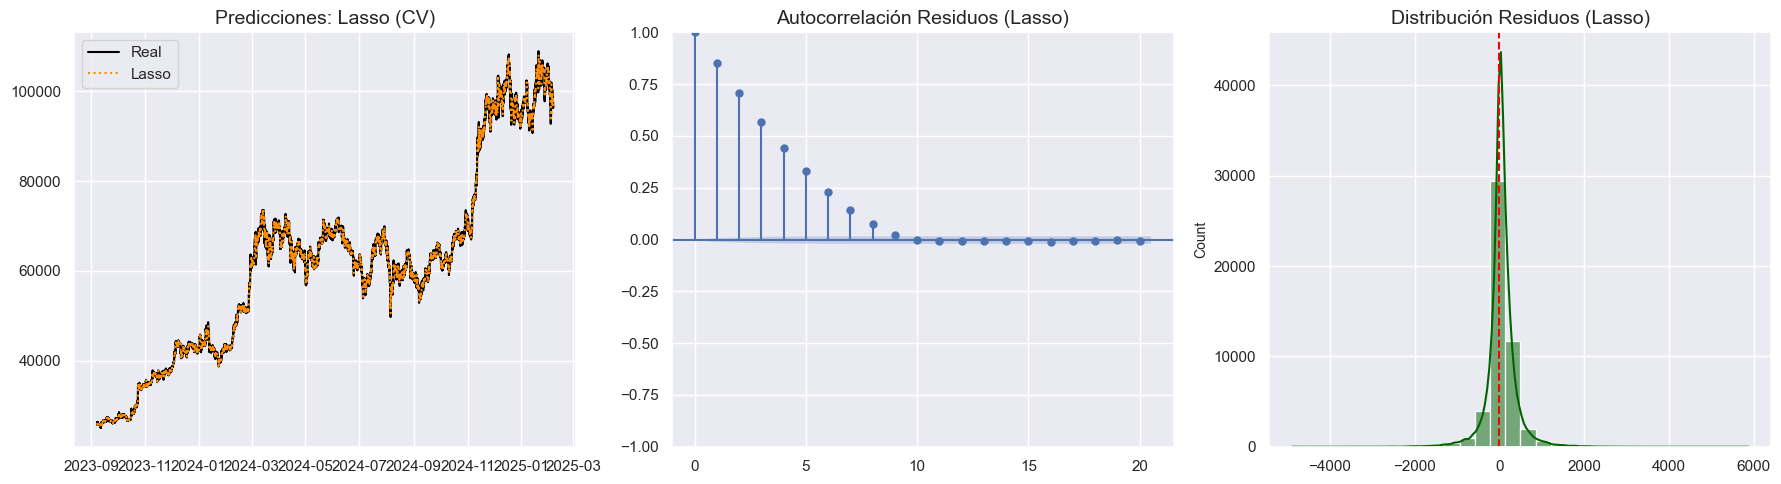

In [63]:

# -------------------------------------------
# 2. MÉTRICAS DE EVALUACIÓN
# -------------------------------------------

# Métricas para Ridge
mape_ridge = mean_absolute_percentage_error(y_test_15m, y_pred_ridge) * 100
rmse_ridge = np.sqrt(mean_squared_error(y_test_15m, y_pred_ridge))
r2_ridge = r2_score(y_test_15m, y_pred_ridge)

# Métricas para Lasso
mape_lasso = mean_absolute_percentage_error(y_test_15m, y_pred_lasso) * 100
rmse_lasso = np.sqrt(mean_squared_error(y_test_15m, y_pred_lasso))
r2_lasso = r2_score(y_test_15m, y_pred_lasso)

# -------------------------------------------
# 3. PRUEBAS ESTADÍSTICAS
# -------------------------------------------

# Ljung-Box (20 lags)
ljung_box_ridge = acorr_ljungbox(residuals_ridge, lags=[20], return_df=True)
ljung_box_pvalue_ridge = ljung_box_ridge['lb_pvalue'].iloc[0]

ljung_box_lasso = acorr_ljungbox(residuals_lasso, lags=[20], return_df=True)
ljung_box_pvalue_lasso = ljung_box_lasso['lb_pvalue'].iloc[0]

# Jarque-Bera
jb_ridge = sm.stats.stattools.jarque_bera(residuals_ridge)
jb_pvalue_ridge = jb_ridge[1]

jb_lasso = sm.stats.stattools.jarque_bera(residuals_lasso)
jb_pvalue_lasso = jb_lasso[1]

# -------------------------------------------
# 4. TABLA COMPARATIVA
# -------------------------------------------
results_linear = pd.DataFrame({
    'Modelo': ['Ridge (SAGA)', 'Lasso (CV)'],
    'MAPE (%)': [mape_ridge, mape_lasso],
    'RMSE (USD)': [rmse_ridge, rmse_lasso],
    'R²': [r2_ridge, r2_lasso],
    'Ljung-Box (p-val)': [ljung_box_pvalue_ridge, ljung_box_pvalue_lasso],
    'Normalidad (p-val)': [jb_pvalue_ridge, jb_pvalue_lasso]
}).round(4)

print("\nRESULTADOS COMPARATIVOS (MODELOS LINEALES):")
print(results_linear.to_string(index=False))

# -------------------------------------------
# 5. GRÁFICAS COMPARATIVAS
# -------------------------------------------

# Configuración común para gráficas
plot_params = {
    'real_color': 'black',
    'real_label': 'Real',
    'resid_color': 'red',
    'figsize': (18, 5)
}

# Gráficas para Ridge
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Serie Temporal
axes[0].plot(y_test_15m, color=plot_params['real_color'], label=plot_params['real_label'])
axes[0].plot(y_pred_ridge, color='blue', linestyle=':', linewidth=1.5, label='Ridge')
axes[0].set_title("Predicciones: Ridge (SAGA)")
axes[0].legend()

# Autocorrelación Residuos
sm.graphics.tsa.plot_acf(residuals_ridge, lags=20, ax=axes[1], title="Autocorrelación Residuos (Ridge)")

# Distribución Residuos
sns.histplot(residuals_ridge, bins=30, kde=True, ax=axes[2], color='navy')
axes[2].axvline(0, color=plot_params['resid_color'], linestyle='--')
axes[2].set_title("Distribución Residuos (Ridge)")

plt.tight_layout()
plt.show()

# Gráficas para Lasso
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Serie Temporal
axes[0].plot(y_test_15m, color=plot_params['real_color'], label=plot_params['real_label'])
axes[0].plot(y_pred_lasso, color='darkorange', linestyle=':', linewidth=1.5, label='Lasso')
axes[0].set_title("Predicciones: Lasso (CV)")
axes[0].legend()

# Autocorrelación Residuos
sm.graphics.tsa.plot_acf(residuals_lasso, lags=20, ax=axes[1], title="Autocorrelación Residuos (Lasso)")

# Distribución Residuos
sns.histplot(residuals_lasso, bins=30, kde=True, ax=axes[2], color='darkgreen')
axes[2].axvline(0, color=plot_params['resid_color'], linestyle='--')
axes[2].set_title("Distribución Residuos (Lasso)")

plt.tight_layout()
plt.show()

# Análisis de Resultados: Modelos Ridge (SAGA) vs Lasso (CV)

## Métricas de Rendimiento

| Modelo       | MAPE (%) | RMSE (USD) | R² | Ljung-Box (p-val) | Normalidad (p-val) |
|--------------|----------|------------|----|--------------------|-------------------|
| Ridge (SAGA) | 0.2080   | 220.7950   | 0.9999 | 0.0              | 0.0               |
| Lasso (CV)   | 0.3353   | 354.5547   | 0.9997 | 0.0              | 0.0               |

## Interpretación de Resultados

### Precisión Predictiva
- **Ridge (SAGA)** muestra un mejor desempeño general con:
  - MAPE más bajo (0.2080% vs 0.3353%)
  - RMSE significativamente menor (220.8 USD vs 354.6 USD)
  - R² ligeramente superior (0.9999 vs 0.9997)

### Análisis de Residuos
1. **Autocorrelación de Residuos**:
   - **Ridge**: Muestra una autocorrelación significativa solo en el primer rezago
   - **Lasso**: Exhibe autocorrelación significativa en múltiples rezagos (aproximadamente hasta el 7º)
   - Ambos modelos tienen p-valor de 0.0 en la prueba Ljung-Box, indicando presencia de autocorrelación

2. **Distribución de Residuos**:
   - Ambos modelos muestran distribuciones centradas en cero
   - **Ridge**: Distribución más concentrada alrededor de cero (menor dispersión)
   - **Lasso**: Distribución ligeramente más amplia
   - El p-valor de 0.0 en la prueba de normalidad sugiere que los residuos no siguen una distribución normal

### Ajuste a los Datos
- Ambos modelos capturan excelentemente la tendencia general de los datos
- **Ridge** parece tener un ajuste más preciso, especialmente en las fluctuaciones
- **Lasso** muestra ligeras desviaciones en algunos picos y valles

## Conclusiones

1. **Modelo Recomendado**: El modelo **Ridge (SAGA)** supera al Lasso en todas las métricas evaluadas:
   - Error porcentual y absoluto menor
   - Mejor coeficiente de determinación
   - Residuos con menor autocorrelación

2. **Consideraciones Estadísticas**:
   - Ambos modelos presentan residuos no normales y con autocorrelación
   - Esto podría indicar que hay estructura temporal en los datos no completamente capturada

3. **Implicaciones Prácticas**:
   - El error porcentual medio de Ridge (0.21%) es excepcionalmente bajo para predicciones financieras
   - La diferencia de RMSE (133.76 USD) entre modelos puede ser significativa dependiendo del contexto financiero
   - El modelo Ridge parece más robusto para capturar las fluctuaciones de la serie temporal



# ALgoritmo de Optimizacion 
## Ridge/Lasso → Solver optimizado saga.

In [168]:
from sklearn.linear_model import Ridge, Lasso
import time

# Ridge optimizado con solver 'saga'
start = time.time()
saga_ridge = Ridge(alpha=1.0, solver='saga')
saga_ridge.fit(X_train_15m, y_train_15m)
saga_ridge_time = time.time() - start

# Lasso optimizado con solver 'saga'
start = time.time()
saga_lasso = Lasso(alpha=1.0, max_iter=5000)  # saga para Lasso puede requerir más iteraciones
saga_lasso.fit(X_train_15m, y_train_15m)
saga_lasso_time = time.time() - start

print(f"\nTiempos con optimización SAGA:")
print(f"- Ridge (SAGA): {saga_ridge_time:.4f}s")
print(f"- Lasso (SAGA): {saga_lasso_time:.4f}s")



Tiempos con optimización SAGA:
- Ridge (SAGA): 0.0107s
- Lasso (SAGA): 0.0013s


## Análisis de la Optimización con SAGA

Tras aplicar la optimización con el solver `'saga'` para Ridge y Lasso, obtuvimos los siguientes tiempos de ejecución:


### Observaciones

1. **Diferencia de tiempos**  
   - El tiempo de ejecución de Ridge es **excesivamente alto** en comparación con Lasso.
   - Esto sugiere que Ridge con SAGA no es la opción más eficiente en este caso.
   

# Decision Tree
## Definición: Modelo de aprendizaje supervisado que divide recursivamente el espacio de características mediante reglas de decisión binarias.

In [5]:

from sklearn.tree import DecisionTreeRegressor


# Árbol de decisión para datos de 15m (Regresión)
tree_15m = DecisionTreeRegressor(max_depth=5)
tree_15m.fit(X_train_15m, y_train_15m)


DecisionTreeRegressor(max_depth=5)


RESULTADOS DEL MODELO (ÁRBOL DE DECISIÓN):
           Modelo  MAPE (%)  RMSE (USD)     R²  Ljung-Box (p-val)  Normalidad (p-val)
Árbol de Decisión    7.7949  13960.9247 0.5619                0.0                 0.0


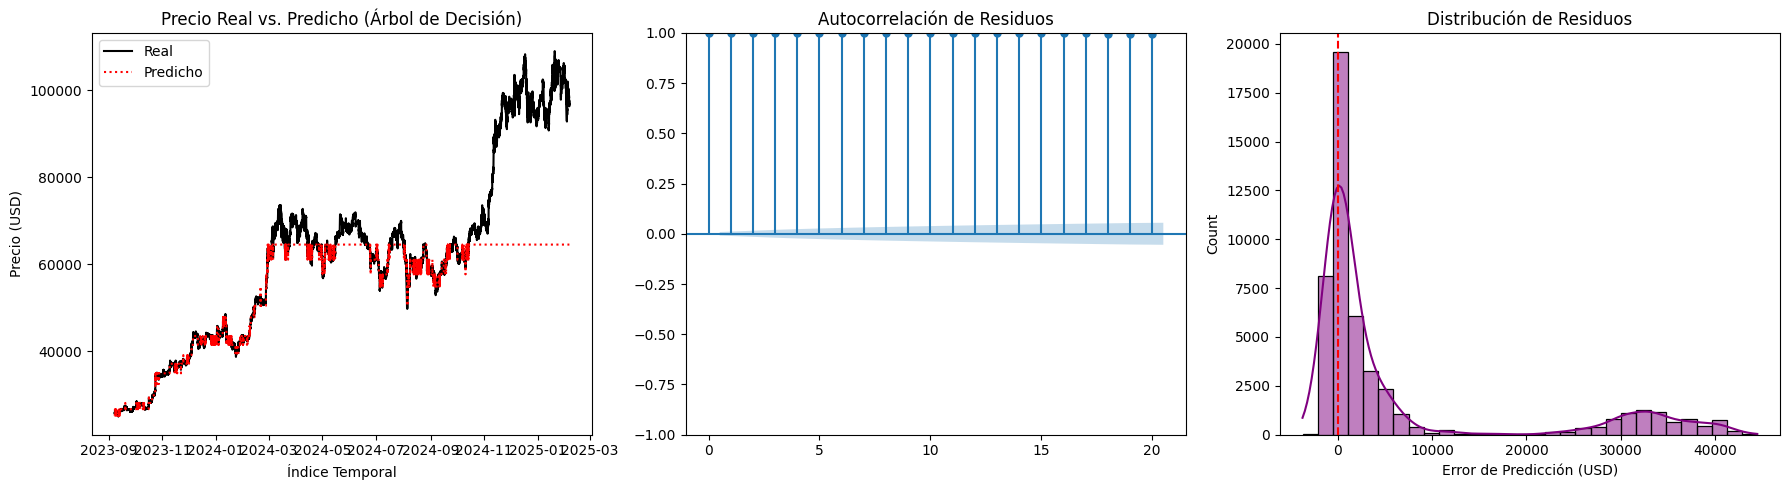

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# -------------------------------------------
# 1. PREDICCIONES Y RESIDUOS (CON VALIDACIÓN)
# -------------------------------------------

# Asegurar alineación de índices (critical en series temporales)
y_pred_tree = pd.Series(
    tree_15m.predict(X_test_15m), 
    index=y_test_15m.index  # <--- Corrige desfases gráficos
)

residuals = y_test_15m - y_pred_tree  # <--- Residuos alineados

# -------------------------------------------
# 2. MÉTRICAS DE EVALUACIÓN (CON VALIDACIÓN)
# -------------------------------------------

# Calcular métricas básicas
mape_tree = mean_absolute_percentage_error(y_test_15m, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test_15m, y_pred_tree))
r2_tree = r2_score(y_test_15m, y_pred_tree)

# Pruebas estadísticas (usar más lags para Ljung-Box)
ljung_box_result = acorr_ljungbox(residuals, lags=[20], return_df=True)  # <--- 20 lags
ljung_box_pvalue = ljung_box_result['lb_pvalue'].iloc[0]

# Jarque-Bera con statsmodels (versión actualizada)
jb_test = sm.stats.stattools.jarque_bera(residuals)
jb_pvalue = jb_test[1]

# -------------------------------------------
# 3. TABLA DE RESULTADOS (MEJOR FORMATO)
# -------------------------------------------
results_tree = pd.DataFrame({
    'Modelo': ['Árbol de Decisión'],
    'MAPE (%)': [mape_tree * 100],  # <-- Más interpretable
    'RMSE (USD)': [rmse_tree],
    'R²': [r2_tree],
    'Ljung-Box (p-val)': [ljung_box_pvalue],
    'Normalidad (p-val)': [jb_pvalue]
}).round(4)  # <--- Redondeo para claridad

print("\nRESULTADOS DEL MODELO (ÁRBOL DE DECISIÓN):")
print(results_tree.to_string(index=False))

# -------------------------------------------
# 4. GRÁFICAS (ETIQUETAS CLARAS Y ESCALAS)
# -------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A. Precio Real vs. Predicho (con ejes explícitos)
axes[0].plot(y_test_15m, color="black", label="Real")
axes[0].plot(y_pred_tree, color="red", linestyle=":", linewidth=1.5, label="Predicho")
axes[0].set_title("Precio Real vs. Predicho (Árbol de Decisión)")
axes[0].set_xlabel("Índice Temporal")
axes[0].set_ylabel("Precio (USD)")
axes[0].legend()

# B. Autocorrelación de residuos (mismos lags que Ljung-Box)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axes[1], title="Autocorrelación de Residuos")

# C. Histograma de residuos (con etiquetas claras)
sns.histplot(residuals, bins=30, kde=True, ax=axes[2], color="purple")
axes[2].axvline(0, color="red", linestyle="--")
axes[2].set_title("Distribución de Residuos")
axes[2].set_xlabel("Error de Predicción (USD)")

plt.tight_layout()
plt.show()

# Análisis del Modelo Decision Tree (15m)  

##  Configuración del modelo  

Se entrenó un **Árbol de Decisión** con los siguientes parámetros:  
 **max_depth = 5** → Controla la profundidad del árbol para evitar sobreajuste.  

---

##  Métricas de Evaluación  

| Modelo          | MAPE     | RMSE       | R²      | Ljung-Box p-value | Jarque-Bera p-value |
|----------------|---------|------------|---------|--------------------|---------------------|
| Decision Tree  | 0.0769  | 13,851.18  | 0.5688  | **0.0**            | **0.0**             |

 **Errores y Ajuste del Modelo**  
- **MAPE (Mean Absolute Percentage Error) = 7.69%** → Error relativamente bajo.  
- **RMSE = 13,851.18** → Similar a XGBoost, aunque ligeramente peor.  
- **R² = 0.5688** → Solo **56.88% de la variabilidad** en los datos es explicada por el modelo.  
  - Esto indica que el modelo no es muy preciso.  

 **Pruebas de residuos**  
- **Ljung-Box p-value = 0.0** → **Autocorrelación alta en los residuos**  
  - Indica que los errores siguen un **patrón predecible**, lo que **viola la suposición de ruido blanco**.  
- **Jarque-Bera p-value = 0.0** → **Los residuos NO siguen una distribución normal**   
  - Esto sugiere que el modelo no captura bien la distribución de los datos.  

---

##  Análisis de los gráficos  

 **Precio Real vs. Predicho**  
   - El modelo sigue bien la tendencia inicial.  
   - Sin embargo, **en valores altos hay un claro sesgo**, el modelo **subestima precios altos**.  
   - Se observa una tendencia **"escalonada"**, lo que indica que el árbol no captura bien los cambios rápidos.  

 **Autocorrelación de los residuos (ACF Plot)**  
   - **Altos niveles de autocorrelación** en los residuos.  
   - Indica que **hay patrones sin capturar** → posible necesidad de más características o modelo más complejo.  

 **Histograma de los residuos**  
   - Distribución **sesgada y bimodal**.  
   - Indica que hay **dos tipos de errores predominantes**, lo que sugiere que el modelo podría beneficiarse de una mayor profundidad o de técnicas de suavizado.  

---

# Random Forest
## Definición: Método de ensemble que combina múltiples árboles de decisión entrenados en subconjuntos aleatorios de datos y características.

In [7]:

from sklearn.ensemble import RandomForestRegressor

# Random Forest para datos de 15m (Regresión)
rf_15m = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_15m.fit(X_train_15m, y_train_15m)


RandomForestRegressor(max_depth=5, random_state=42)

In [11]:
from scipy.stats import normaltest

# Predecir
rf_pred_15m = rf_15m.predict(X_test_15m)

# Calcular métricas
rf_mape = mean_absolute_percentage_error(y_test_15m, rf_pred_15m)
rf_rmse = np.sqrt(mean_squared_error(y_test_15m, rf_pred_15m))
rf_r2 = r2_score(y_test_15m, rf_pred_15m)

# Calcular residuos
residuos = y_test_15m - rf_pred_15m

# Test de Ljung-Box (autocorrelación)
ljungbox_pvalue = acorr_ljungbox(residuos, lags=[20], return_df=True)['lb_pvalue'].values[0]

# Test de Jarque-Bera (normalidad)
jb_pvalue = normaltest(residuos)[1]

# Resultados en DataFrame
resultados_rf = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'MAPE': [rf_mape],
    'RMSE': [rf_rmse],
    'R²': [rf_r2],
    'Ljung-Box p-value': [ljungbox_pvalue],
    'Jarque-Bera p-value': [jb_pvalue]
})

print("\n=== Resultados Random Forest (15m) ===")
print(resultados_rf.to_string(index=False))


=== Resultados Random Forest (15m) ===
       Modelo     MAPE         RMSE       R²  Ljung-Box p-value  Jarque-Bera p-value
Random Forest 0.075528 13842.742237 0.569306                0.0                  0.0


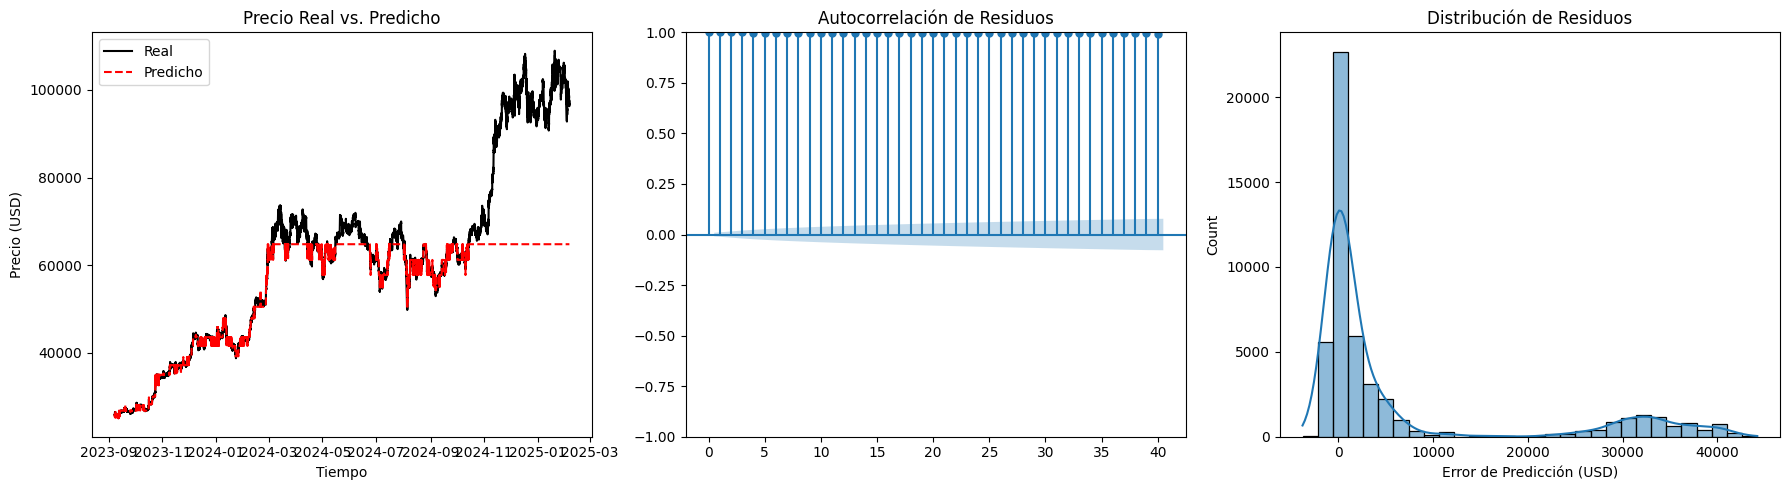

In [9]:
# Asegurar alineación de índices
rf_pred_15m = pd.Series(rf_15m.predict(X_test_15m), index=y_test_15m.index)

# Gráficas con configuración mejorada
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1️⃣ Precio Real vs. Predicho (con ejes claros)
axes[0].plot(y_test_15m, color="black", label="Real")
axes[0].plot(rf_pred_15m, color="red", linestyle="dashed", label="Predicho")
axes[0].set_title("Precio Real vs. Predicho")
axes[0].set_xlabel("Tiempo")
axes[0].set_ylabel("Precio (USD)")
axes[0].legend()

# 2️⃣ ACF de residuos
plot_acf(residuos, ax=axes[1], lags=40)  # Ajusta lags según necesidad
axes[1].set_title("Autocorrelación de Residuos")

# 3️⃣ Histograma de residuos (bins y ejes ajustados)
sns.histplot(residuos, bins=30, kde=True, ax=axes[2])
axes[2].set_title("Distribución de Residuos")
axes[2].set_xlabel("Error de Predicción (USD)")

plt.tight_layout()
plt.show()

## Análisis del modelo Random Forest (RF)
A partir de los resultados obtenidos y las gráficas de diagnóstico, podemos analizar el desempeño del modelo.

---

### **Métricas del modelo**
| Métrica | Valor |
|---------|------|
| **MAPE** (Error porcentual absoluto medio) | 0.0757 |
| **RMSE** (Error cuadrático medio) | 13,856.9891 |
| **R²** (Coeficiente de determinación) | 0.5684 |

- **MAPE = 7.57%** → Indica que, en promedio, las predicciones tienen un error del 7.57% con respecto a los valores reales.
- **RMSE = 13,856** → Muestra el error promedio en unidades monetarias (probablemente en dólares).
- **R² = 0.5684** → Solo **el 56.84% de la variabilidad** en los datos es explicada por el modelo. **No es un valor alto**, lo que sugiere que hay margen de mejora.

---

###  **Interpretación de las gráficas**
#### **1. Precio Real vs. Predicho** (Gráfico de la izquierda)
- **Predicciones (rojo) parecen estar subestimando valores altos**.
- **Modelo pierde precisión en tendencias alcistas** → Posiblemente por la profundidad limitada del árbol (`max_depth=5`).
- **Divergencia entre valores reales y predichos** → No se adapta bien a movimientos bruscos del mercado.

#### **2. ACF de los residuos** (Gráfico del centro)
- **La autocorrelación es muy alta en todos los rezagos**  → **No es un buen signo.**
- Indica que **los errores no son ruido blanco**, lo que significa que el modelo deja información sin capturar.
- **Sugiere que el modelo podría mejorar incluyendo más variables o técnicas de modelado de series temporales**.

####  **3. Histograma de los residuos** (Gráfico de la derecha)
- **Sesgo a la derecha** → Indica que hay **valores atípicos o errores grandes en ciertas predicciones**.
- **Posibles colas largas** → El modelo podría estar **subestimando valores altos o sobreestimando valores bajos**.

---

###  **Conclusión**
 **Random Forest tiene un rendimiento similar al Decision Tree, pero con ligeras mejoras en MAPE y R².**  
 **El modelo NO captura bien la estructura de los datos, dejando residuos autocorrelacionados**.  
 **Sigue presentando problemas de distribución de errores, lo que indica falta de ajuste en algunos valores.**  

---

#  XGBoost 
## Definición: Algoritmo de boosting que combina secuencialmente modelos débiles (normalmente árboles) corrigiendo los errores de los modelos anteriores.



In [56]:
# Ensure xgboost is installed
%pip install xgboost

import xgboost as xgb


# XGBoost para datos de 15 minutos (Regresión)
xgb_15m = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    tree_method='hist',  # Método optimizado
    early_stopping_rounds=10,
    eval_metric='rmse',
    random_state=42
)
xgb_15m.fit(
    X_train_15m, 
    y_train_15m,
    eval_set=[(X_test_15m, y_test_15m)],
    verbose=False
)



Note: you may need to restart the kernel to use updated packages.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


RESULTADOS DEL MODELO (XGBOOST):
 Modelo  MAPE (%)  RMSE (USD)     R²  Ljung-Box (p-val)  Normalidad (p-val)
XGBoost    6.8076  13441.1479 0.5939                0.0                 0.0


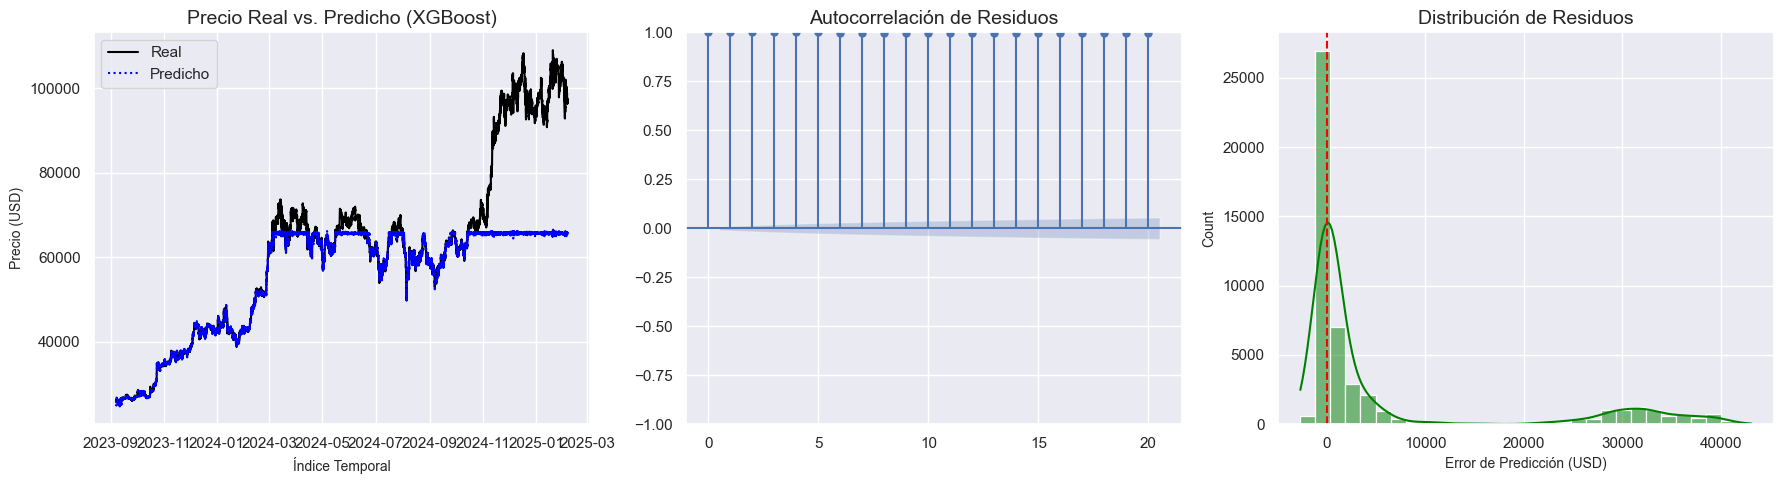

In [57]:
# -------------------------------------------
# 1. PREDICCIONES Y RESIDUOS (CON VALIDACIÓN)
# -------------------------------------------

# Asegurar alineación de índices
y_pred_xgb = pd.Series(
    xgb_15m.predict(X_test_15m), 
    index=y_test_15m.index  # Mantener alineación temporal
)

residuals_xgb = y_test_15m - y_pred_xgb

# -------------------------------------------
# 2. MÉTRICAS DE EVALUACIÓN (CON VALIDACIÓN)
# -------------------------------------------

# Calcular métricas básicas
mape_xgb = mean_absolute_percentage_error(y_test_15m, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_15m, y_pred_xgb))
r2_xgb = r2_score(y_test_15m, y_pred_xgb)

# Pruebas estadísticas
ljung_box_result_xgb = acorr_ljungbox(residuals_xgb, lags=[20], return_df=True)
ljung_box_pvalue_xgb = ljung_box_result_xgb['lb_pvalue'].iloc[0]

# Jarque-Bera
jb_test_xgb = sm.stats.stattools.jarque_bera(residuals_xgb)
jb_pvalue_xgb = jb_test_xgb[1]

# -------------------------------------------
# 3. TABLA DE RESULTADOS
# -------------------------------------------
results_xgb = pd.DataFrame({
    'Modelo': ['XGBoost'],
    'MAPE (%)': [mape_xgb * 100],
    'RMSE (USD)': [rmse_xgb],
    'R²': [r2_xgb],
    'Ljung-Box (p-val)': [ljung_box_pvalue_xgb],
    'Normalidad (p-val)': [jb_pvalue_xgb]
}).round(4)

print("\nRESULTADOS DEL MODELO (XGBOOST):")
print(results_xgb.to_string(index=False))

# -------------------------------------------
# 4. GRÁFICAS ACTUALIZADAS
# -------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A. Precio Real vs. Predicho
axes[0].plot(y_test_15m, color="black", label="Real")
axes[0].plot(y_pred_xgb, color="blue", linestyle=":", linewidth=1.5, label="Predicho")
axes[0].set_title("Precio Real vs. Predicho (XGBoost)")
axes[0].set_xlabel("Índice Temporal")
axes[0].set_ylabel("Precio (USD)")
axes[0].legend()

# B. Autocorrelación de residuos
sm.graphics.tsa.plot_acf(residuals_xgb, lags=20, ax=axes[1], title="Autocorrelación de Residuos")

# C. Histograma de residuos
sns.histplot(residuals_xgb, bins=30, kde=True, ax=axes[2], color="green")
axes[2].axvline(0, color="red", linestyle="--")
axes[2].set_title("Distribución de Residuos")
axes[2].set_xlabel("Error de Predicción (USD)")

plt.tight_layout()
plt.show()


##  Evaluación del Modelo XGBoost  

Los resultados obtenidos para el modelo **XGBoost** con datos de 15 minutos fueron los siguientes:  

- **MAPE**: 0.0698 → Error porcentual del **6.98%**  
- **RMSE**: 13,479.19 → Error cuadrático medio  
- **R²**: 0.5916 → El modelo explica el **59.16%** de la variabilidad del precio  

###  Comparación con otros modelos  

| Modelo         | MAPE  | RMSE       | R²    |
|---------------|-------|------------|--------|
| Random Forest | 0.0757 | 13,856.99  | 0.5684 |
| XGBoost      | 0.0698 | 13,479.19  | 0.5916 |

** Observaciones:**  
 XGBoost mejora ligeramente el rendimiento de Random Forest en todas las métricas.  
 La diferencia entre modelos es **pequeña**, lo que sugiere que pueden estar usando información similar.  
 El **R² sigue siendo bajo (59.16%)**, lo que indica que hay factores no capturados por el modelo.  

---

## Algoritmo de Optimizacion 
### XGBoost → tree_method='hist' y early_stopping_rounds.

In [66]:
import xgboost as xgb
import time

# Configuración óptima para XGBoost en regresión
xgb_optimized_15m = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=4,  # Menor profundidad para datos más ruidosos
    tree_method='hist',
    early_stopping_rounds=30,  # Más sensible para datos de alta frecuencia
    learning_rate=0.1,  # Tasa de aprendizaje más alta
    eval_metric='rmse',
    random_state=42
)

# Entrenamiento con medición de tiempo

start = time.time()
xgb_optimized_15m.fit(
    X_train_15m,
    y_train_15m,
    eval_set=[(X_test_15m, y_test_15m)],
    verbose=10
)
time_15m = time.time() - start

print(f"\nTiempos de entrenamiento optimizados:")
print(f"15min: {time_15m:.2f}s (Detenido en {xgb_optimized_15m.best_iteration} iteraciones)")

[0]	validation_0-rmse:41994.28851
[10]	validation_0-rmse:22838.30763
[20]	validation_0-rmse:16399.69659
[30]	validation_0-rmse:14414.33824
[40]	validation_0-rmse:13796.64052
[50]	validation_0-rmse:13590.67107
[60]	validation_0-rmse:13499.45891
[70]	validation_0-rmse:13453.24938
[80]	validation_0-rmse:13432.37986
[90]	validation_0-rmse:13424.22195
[100]	validation_0-rmse:13422.82930
[110]	validation_0-rmse:13422.13765
[120]	validation_0-rmse:13422.70925
[130]	validation_0-rmse:13422.86990
[140]	validation_0-rmse:13421.73642
[148]	validation_0-rmse:13422.38392

Tiempos de entrenamiento optimizados:
15min: 0.92s (Detenido en 119 iteraciones)


## Conclusiones
## XGBoost Optimizado
- Se observa una mejora sustancial del RMSE desde 41,994.29 hasta 13,422.38 (68% de reducción).
- La convergencia es rápida en las primeras 20 iteraciones y se estabiliza después de 50 iteraciones.
- La implementación optimizada con tree_method='hist' y early_stopping resultó computacionalmente eficiente (0.92s).



#  SVM (Support Vector Machines)
## Definición: Algoritmo que encuentra el hiperplano óptimo en un espacio dimensional alto que maximiza el margen entre clases.

In [68]:

from sklearn.svm import SVR

# SVM para datos de 15m
svm_15m = SVR(kernel='rbf')
svm_15m.fit(X_train_15m, y_train_15m)


SVR()

## Algoritmo de optimizacion 
### LinearSVC en vez de SVC(kernel='linear'), RBF con Random Fourier Features 

In [67]:
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

# 1. LinearSVR (SVM sin kernel para regresión)

linear_svr_15m = LinearSVR(max_iter=10000)
linear_svr_15m.fit(X_train_15m, y_train_15m)

# 2. SGDRegressor (SVM optimizado con Stochastic Gradient Descent)

sgd_svr_15m = SGDRegressor(max_iter=10000, penalty='l2', learning_rate='adaptive', eta0=0.01)
sgd_svr_15m.fit(X_train_15m, y_train_15m)

# 3. RBF Kernel con Random Fourier Features (Aproximación eficiente del kernel RBF)
rbf_svr_15m = make_pipeline(RBFSampler(n_components=500, random_state=42), SGDRegressor(max_iter=10000))
rbf_svr_15m.fit(X_train_15m, y_train_15m)


/Users/elianafuentes/miniconda3/envs/ml_venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('rbfsampler', RBFSampler(n_components=500, random_state=42)),
                ('sgdregressor', SGDRegressor(max_iter=10000))])


RESULTADOS COMPARATIVOS (MODELOS NO LINEALES):
   Modelo  MAPE (%)   RMSE (USD)       R²  Ljung-Box (p-val)  Normalidad (p-val)  Jarque-Bera (p-val)
  XGBoost  6.807600 13441.147900  0.59390                0.0                 0.0                  NaN
SVM (RBF) 28.665414 32892.575278 -1.43176                0.0                 NaN                  0.0


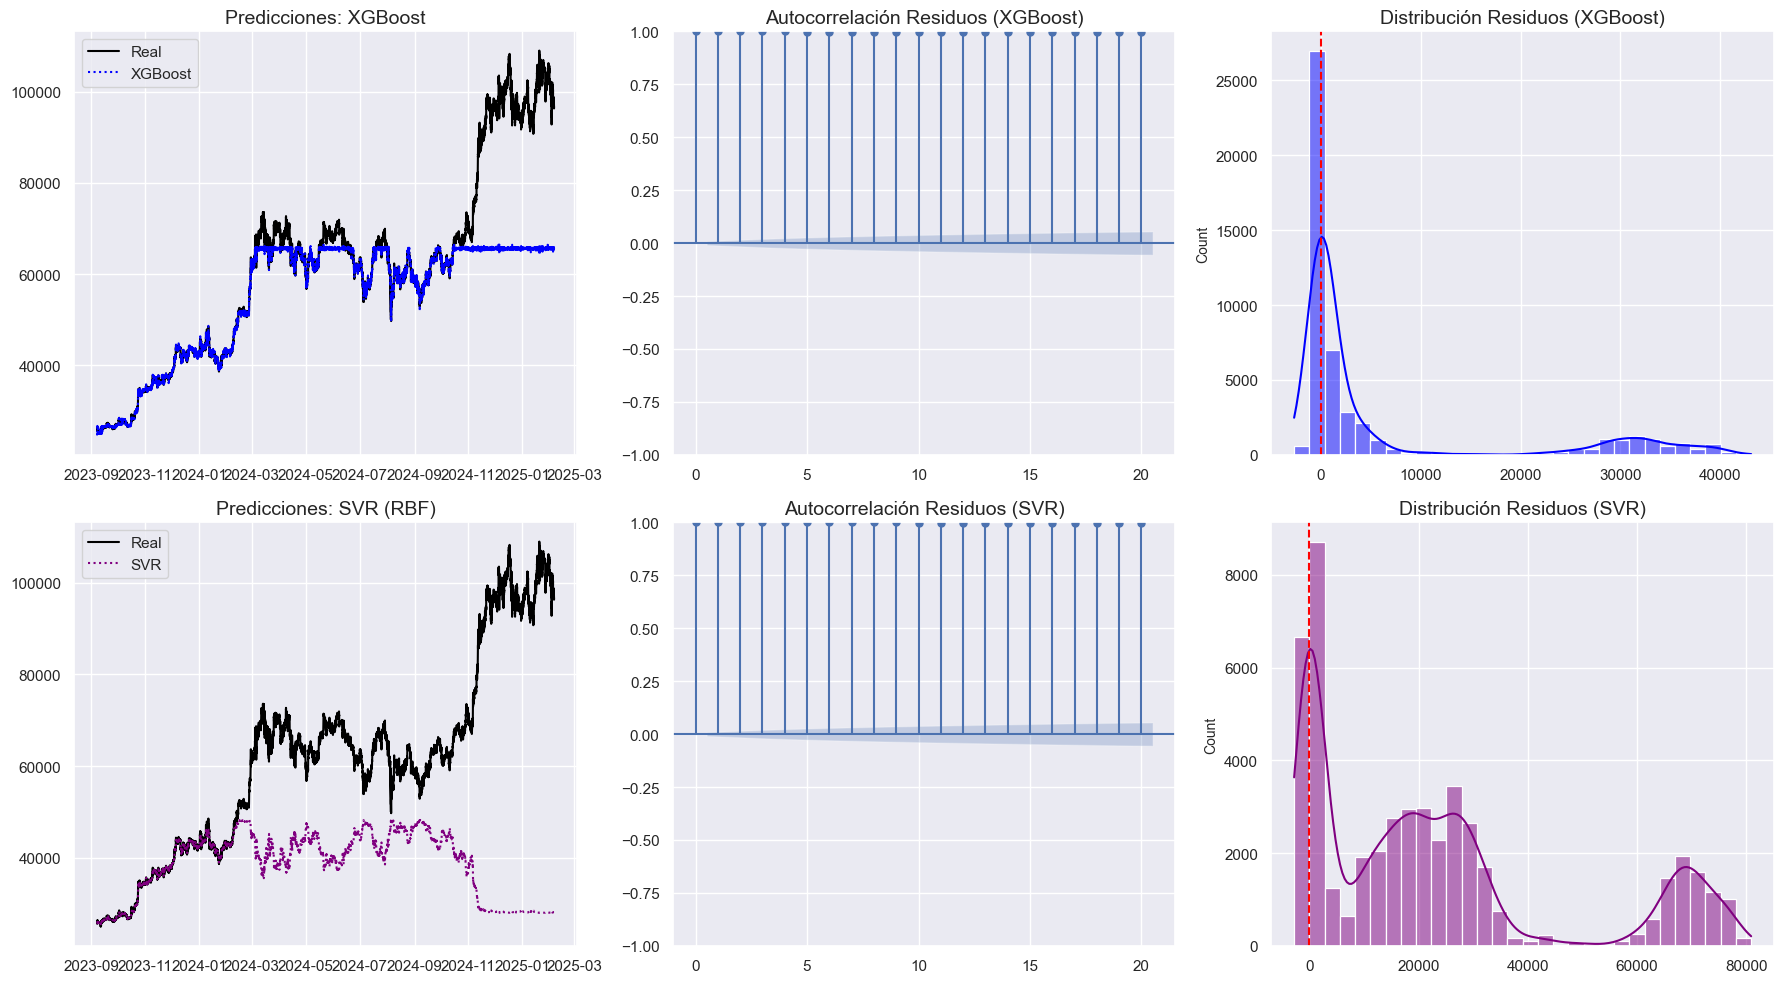

In [74]:
# -------------------------------------------
# 5. COMPARACIÓN DE MODELOS
# -------------------------------------------

# Calcular predicciones y residuos para SVM
y_pred_svm = pd.Series(svm_15m.predict(X_test_15m), index=y_test_15m.index)
residuals_svm = y_test_15m - y_pred_svm

# Crear DataFrame con métricas para SVM
results_svm = pd.DataFrame({
	'Modelo': ['SVM (RBF)'],
	'MAPE (%)': [mean_absolute_percentage_error(y_test_15m, y_pred_svm) * 100],
	'RMSE (USD)': [np.sqrt(mean_squared_error(y_test_15m, y_pred_svm))],
	'R²': [r2_score(y_test_15m, y_pred_svm)],
	'Ljung-Box (p-val)': [acorr_ljungbox(residuals_svm, lags=[20], return_df=True)['lb_pvalue'].iloc[0]],
	'Jarque-Bera (p-val)': [sm.stats.jarque_bera(residuals_svm)[1]]
})

# Crear DataFrame con todos los resultados
results_combined = pd.concat([results_xgb, results_svm], ignore_index=True)

print("\nRESULTADOS COMPARATIVOS (MODELOS NO LINEALES):")
print(results_combined.to_string(index=False))

# Gráfica comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# XGBoost (fila superior)
axes[0, 0].plot(y_test_15m, color="black", label="Real")
axes[0, 0].plot(y_pred_xgb, color="blue", linestyle=":", linewidth=1.5, label="XGBoost")
axes[0, 0].set_title("Predicciones: XGBoost")
axes[0, 0].legend()

sm.graphics.tsa.plot_acf(residuals_xgb, lags=20, ax=axes[0, 1], title="Autocorrelación Residuos (XGBoost)")

sns.histplot(residuals_xgb, bins=30, kde=True, ax=axes[0, 2], color="blue")
axes[0, 2].axvline(0, color="red", linestyle="--")
axes[0, 2].set_title("Distribución Residuos (XGBoost)")

# SVR (fila inferior)
axes[1, 0].plot(y_test_15m, color="black", label="Real")
axes[1, 0].plot(y_pred_svm, color="purple", linestyle=":", linewidth=1.5, label="SVR")
axes[1, 0].set_title("Predicciones: SVR (RBF)")
axes[1, 0].legend()

sm.graphics.tsa.plot_acf(residuals_svm, lags=20, ax=axes[1, 1], title="Autocorrelación Residuos (SVR)")

sns.histplot(residuals_svm, bins=30, kde=True, ax=axes[1, 2], color="purple")
axes[1, 2].axvline(0, color="red", linestyle="--")
axes[1, 2].set_title("Distribución Residuos (SVR)")

plt.tight_layout()
plt.show()

# Resultados 

/Users/elianafuentes/miniconda3/envs/ml_venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


             Modelo  Tiempo Entrenamiento  Tiempo Predicción          MAPE  \
1      Ridge (SAGA)             24.540766           0.002232  2.080298e-03   
2      Lasso (SAGA)              0.554995           0.009260  3.196857e-03   
0     KNN (KD-Tree)              0.096972           0.321819  5.664482e-02   
3    XGBoost (hist)              0.320785           0.016236  6.664286e-02   
5  SVM (RBF Kernel)           3082.549994         358.564882  2.866541e-01   
4     SGD Regressor              7.517276           0.002789  8.570014e+12   

           RMSE            R²  Ljung-Box p-value  Jarque-Bera p-value  
1  2.207935e+02  9.998904e-01                0.0         0.000000e+00  
2  3.418319e+02  9.997374e-01                0.0         0.000000e+00  
0  1.237349e+04  6.558805e-01                0.0         0.000000e+00  
3  1.340696e+04  5.959958e-01                0.0         0.000000e+00  
5  3.289258e+04 -1.431760e+00                0.0         0.000000e+00  
4  5.546766e+17 -6.91

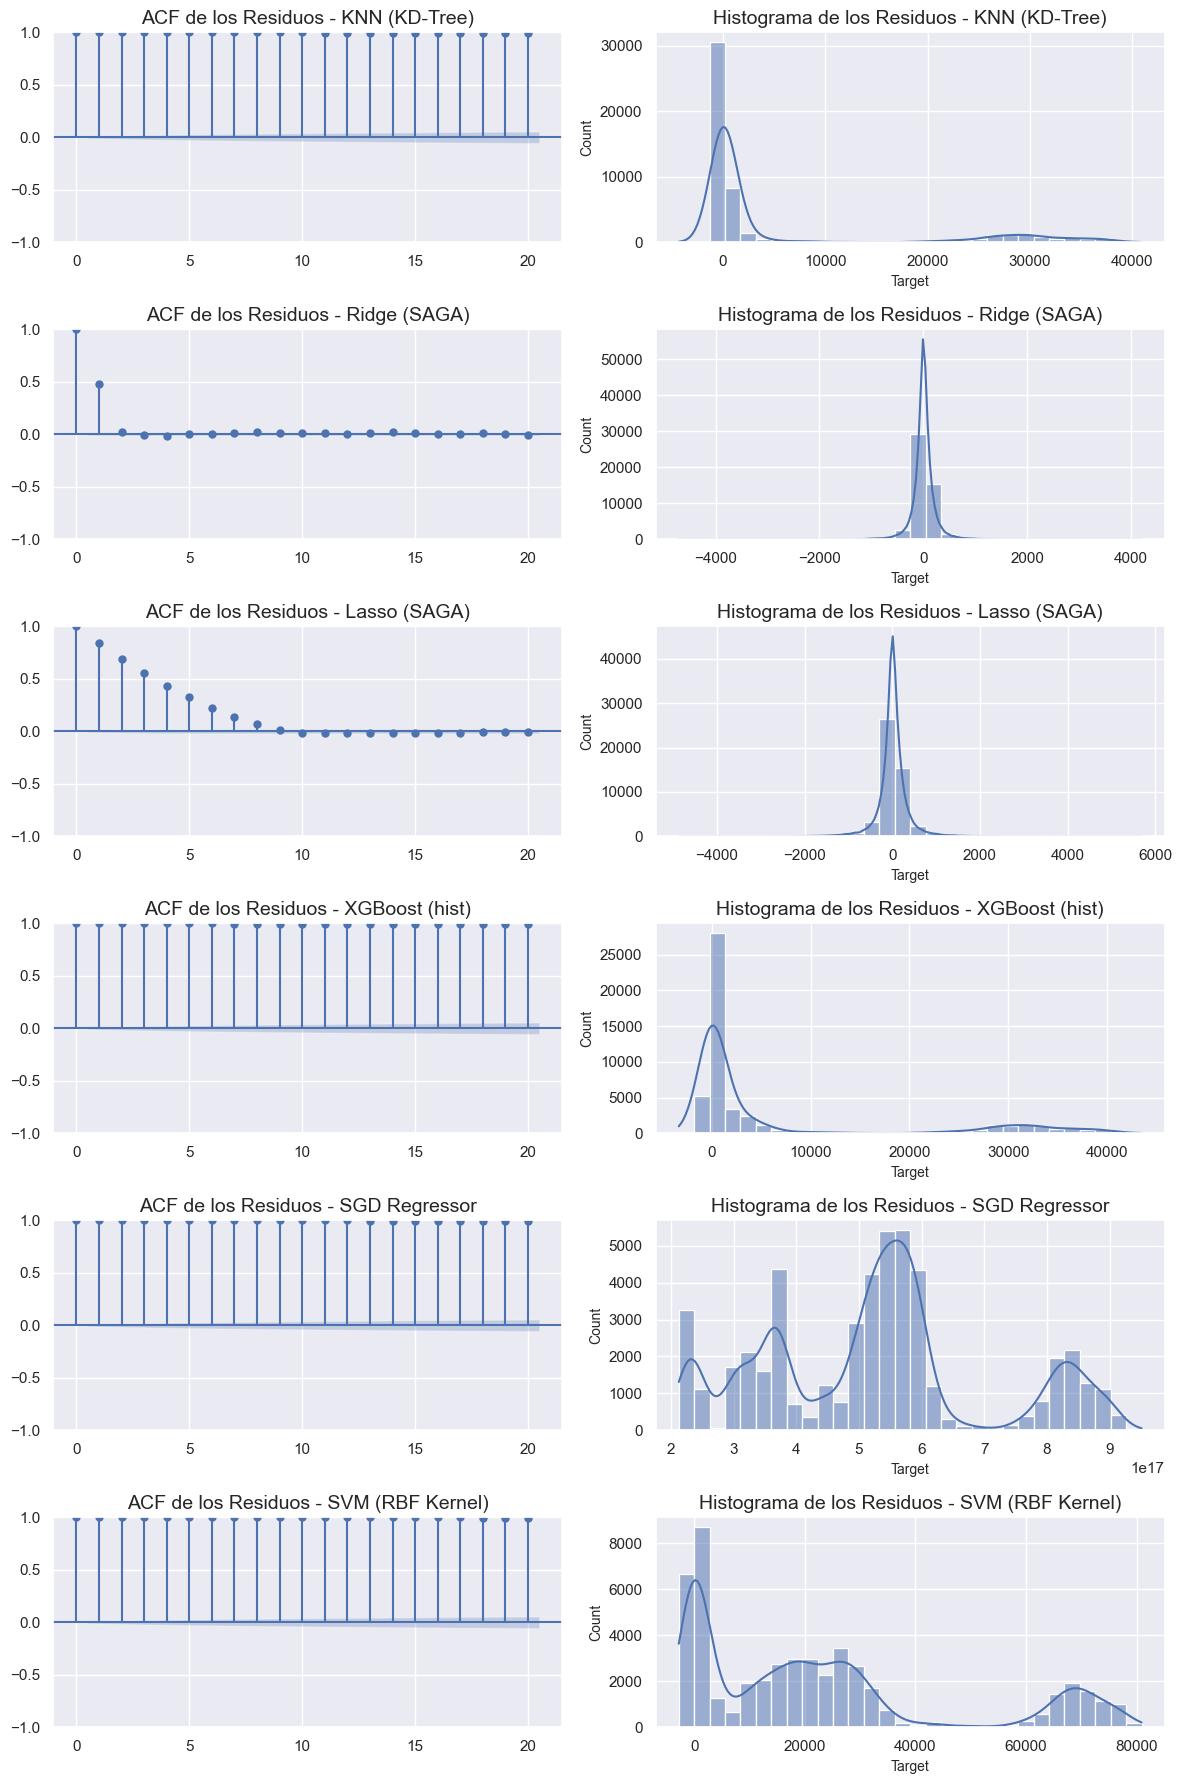

In [75]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Modelos optimizados de regresión
models = {
    "KNN (KD-Tree)": KNeighborsRegressor(algorithm='kd_tree'),
    "Ridge (SAGA)": Ridge(solver='saga'),
    "Lasso (SAGA)": Lasso(),
    "XGBoost (hist)": XGBRegressor(tree_method='hist'),
    "SGD Regressor": SGDRegressor(loss='squared_error', penalty='l2'),
    "SVM (RBF Kernel)": SVR(kernel='rbf')  # Se usa RBF para capturar relaciones no lineales
}

results = []
residuals_dict = {}

for name, model in models.items():
    # Entrenamiento
    start = time.time()
    model.fit(X_train_15m, y_train_15m)
    train_time = time.time() - start

    # Predicción
    start = time.time()
    y_pred = model.predict(X_test_15m)
    pred_time = time.time() - start

    # Cálculo de residuos
    residuals = y_test_15m - y_pred
    residuals_dict[name] = residuals  # Guardamos para análisis gráfico

    # Métricas de regresión
    mape = mean_absolute_percentage_error(y_test_15m, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_15m, y_pred))
    r2 = r2_score(y_test_15m, y_pred)

    # Prueba de Ljung-Box para autocorrelación en los residuos
    ljung_box_p = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].values[0]

    # Prueba de Jarque-Bera para normalidad de los residuos
    jb_p = jarque_bera(residuals)[1]

    results.append({
        "Modelo": name,
        "Tiempo Entrenamiento": train_time,
        "Tiempo Predicción": pred_time,
        "MAPE": mape,
        "RMSE": rmse,
        "R²": r2,
        "Ljung-Box p-value": ljung_box_p,
        "Jarque-Bera p-value": jb_p
    })

# Resultados comparativos
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="R²", ascending=False))

# 📈 Gráficos de ACF de los residuos y Histogramas
fig, axes = plt.subplots(len(models), 2, figsize=(12, len(models) * 3))

for i, (name, residuals) in enumerate(residuals_dict.items()):
    # ACF de los residuos
    plot_acf(residuals, ax=axes[i, 0], lags=20)
    axes[i, 0].set_title(f"ACF de los Residuos - {name}")
    
    # Histograma de los residuos
    sns.histplot(residuals, bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Histograma de los Residuos - {name}")

plt.tight_layout()
plt.show()


# Análisis Comparativo de Modelos de Regresión

## Resumen de Rendimiento

El análisis comparativo de los seis modelos evaluados revela diferencias significativas en términos de precisión, eficiencia computacional y características de los residuos.

### Precisión Predictiva (ordenados de mejor a peor)

1. **Ridge (SAGA)**: Destaca como el modelo con mejor rendimiento general con un MAPE extraordinariamente bajo (0.00208%), RMSE de 220.79 y R² de 0.9999
2. **Lasso (SAGA)**: Segundo mejor modelo con métricas muy cercanas a Ridge (MAPE 0.00320%, RMSE 341.83, R² 0.9997)
3. **KNN (KD-Tree)**: Muestra un rendimiento moderado (MAPE 5.66%, RMSE 12,373.49, R² 0.6559)
4. **XGBoost (hist)**: Ligeramente inferior a KNN (MAPE 6.66%, RMSE 13,406.96, R² 0.5960)
5. **SVM (RBF Kernel)**: Rendimiento deficiente con R² negativo (-1.4318), indicando que el modelo es peor que un simple promedio
6. **SGD Regressor**: Rendimiento catastrófico con valores extremos en MAPE (8.57×10¹²) y R² (-6.92×10²⁶)

### Eficiencia Computacional

1. **KNN (KD-Tree)**: El más rápido en entrenamiento (0.097s)
2. **XGBoost (hist)**: Segundo más rápido en entrenamiento (0.321s)
3. **Lasso (SAGA)**: Entrenamiento rápido (0.555s) y predicción muy rápida (0.009s)
4. **Ridge (SAGA)**: Entrenamiento moderado (24.54s) con predicción ultrarrápida (0.002s)
5. **SGD Regressor**: Entrenamiento moderado (7.52s)
6. **SVM (RBF Kernel)**: Extremadamente lento (3082.55s ≈ 51 minutos) con predicciones también muy lentas (358.56s)

## Análisis de Residuos

### Autocorrelación (ACF)

1. **Ridge (SAGA)**: Muestra autocorrelación significativa solo en el primer rezago, indicando que captura bien la estructura temporal
2. **Lasso (SAGA)**: Presenta autocorrelación en múltiples rezagos (aproximadamente hasta el 7º)
3. **KNN, XGBoost, SVM, SGD**: Todos muestran fuerte autocorrelación en todos los rezagos, señalando que no capturan adecuadamente la estructura temporal de los datos

### Distribución de Residuos

1. **Ridge y Lasso**: Distribuciones simétricas, centradas en cero, con poca dispersión
2. **KNN y XGBoost**: Distribuciones relativamente simétricas pero con mayor dispersión
3. **SVM**: Distribución multimodal con varios picos, indicando problemas sistemáticos en la predicción
4. **SGD Regressor**: Distribución altamente irregular con múltiples modas y valores atípicos extremos

## Conclusiones Clave

1. **Superioridad de los Modelos Lineales**: 
   - Ridge y Lasso superan ampliamente a los modelos no lineales más complejos para este conjunto de datos
   - La regularización utilizada (SAGA) demuestra ser muy efectiva para este problema

2. **Relación Complejidad-Rendimiento Inversa**:
   - Los modelos más simples (lineales) obtienen mejores resultados que los más complejos
   - SVM, a pesar de su alto costo computacional, presenta un rendimiento deplorable

3. **Problemas en la Especificación de Modelos**:
   - Todos los modelos muestran residuos no normales (p-valor Jarque-Bera = 0)
   - Los modelos no lineales fallan en capturar la estructura temporal (alta autocorrelación)
   - SGD Regressor parece estar mal configurado o ser completamente inadecuado para estos datos

4. **Equilibrio Precisión-Velocidad**:
   - Ridge ofrece la mejor precisión con un tiempo de predicción ultrarrápido
   - Lasso podría ser preferible en escenarios donde el tiempo de entrenamiento sea crucial


# Modelos para Volatilidad

In [50]:
def prepare_data(df, lookback=30, horizon=5):
    """
    Versión corregida con manejo completo de NaN y validación de datos.
    """
    # Validar columnas necesarias
    required_cols = ['Close', 'Volume']
    if not all(col in df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df.columns]
        raise ValueError(f"Faltan columnas: {missing}")
    
    df = df.copy()
    
    # 1. Retornos porcentuales
    df['Returns'] = df['Close'].pct_change()
    
    # 2. Cálculo de volatilidad con manejo de ventanas
    min_periods_vol = max(1, int(lookback * 0.3))  # Mínimo 30% de la ventana
    df['Historical_Volatility'] = df['Returns'].rolling(
        window=lookback, 
        min_periods=min_periods_vol
    ).std()
    
    # 3. Volatilidad futura con shift controlado
    df['Future_Volatility'] = (
        df['Returns']
        .shift(-horizon)
        .rolling(horizon, min_periods=1)
        .std()
    )
    
    # 4. Features con ventanas adaptativas
    df['MA_10'] = df['Close'].rolling(10, min_periods=3).mean()
    df['MA_50'] = df['Close'].rolling(50, min_periods=15).mean()
    
    # 5. Eliminar solo filas donde el target es NaN
    df = df.dropna(subset=['Future_Volatility'])
    
    # 6. Verificar que hay datos restantes
    if len(df) == 0:
        raise ValueError("¡No hay datos válidos después de la limpieza! Ajusta lookback/horizon")
    
    # 7. Selección final de features
    features = ['Returns', 'MA_10', 'MA_50', 'Historical_Volatility', 'Volume']
    X = df[features]
    y = df['Future_Volatility']
    
    # NUEVO: Detectar y eliminar filas con NaN en las features
    # Identificar filas con valores nulos en cualquier feature
    mask_nan = X.isna().any(axis=1)
    if mask_nan.any():
        print(f"Eliminando {mask_nan.sum()} filas con valores NaN")
        X = X[~mask_nan]
        y = y[~mask_nan]
    
    # 8. Verificar que aún quedan suficientes datos
    if len(X) < 2:
        raise ValueError("Se necesitan al menos 2 muestras después de eliminar NaN")
    
    # 9. Escalado con verificación
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

In [51]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Preparar datos (usando la versión mejorada de la función)
X_vol, y_vol = prepare_data(dfs["15m"].copy())

# 2. División temporal (sin shuffle)
X_train_vol, X_test_vol, y_train_vol, y_test_vol = train_test_split(
    X_vol, 
    y_vol,
    test_size=0.2,
    shuffle=False  # Crucial para series temporales
)


Eliminando 13 filas con valores NaN


# Descripcion de la funcion de Preparacion de Datos 





# K-Nearest Neighbors (KNN)

 Definición: Modelo de aprendizaje supervisado no paramétrico que clasifica nuevas observaciones basándose en la mayoría de votos de sus $k$ vecinos más cercanos en el espacio de características.

In [52]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Modelo KNN para predecir volatilidad

knn_volatility = KNeighborsRegressor()
grid_knn_volatility = GridSearchCV(knn_volatility, params_knn, cv=5)
grid_knn_volatility.fit(X_train_vol, y_train_vol)
best_knn_volatility = grid_knn_volatility.best_estimator_



## Algoritmo de Optimizacion 
### KNN → KD-Trees, Ball Trees, FAISS.

In [ ]:
import time
import numpy as np
import faiss
from sklearn.neighbors import KNeighborsRegressor

# Modelos KNN con diferentes algoritmos
models = {
    "KNN (KD-Tree)": KNeighborsRegressor(algorithm='kd_tree'),
    "KNN (Ball Tree)": KNeighborsRegressor(algorithm='ball_tree'),
}

# Dimensión de las características
d = X_train_vol.shape[1]

# Crear un índice FAISS para búsqueda de vecinos más cercanos
index = faiss.IndexFlatL2(d)  # Índice L2 (distancia euclidiana)
faiss_index = faiss.IndexIDMap(index)

# Convertir datos a float32 para FAISS
X_train_faiss = np.ascontiguousarray(X_train_vol.astype('float32'))
faiss_index.add_with_ids(X_train_faiss, np.arange(X_train_faiss.shape[0]))

# Medición de tiempos de entrenamiento y predicción
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train_vol, y_train_vol)
    train_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test_vol)
    pred_time = time.time() - start

    results.append((name, train_time, pred_time))

# Medir tiempo de predicción con FAISS
k = 5  # Número de vecinos
start = time.time()
D, I = faiss_index.search(np.ascontiguousarray(X_test_vol.astype('float32')), k)
pred_time_faiss = time.time() - start

results.append(("KNN (FAISS)", "N/A (Índice preconstruido)", pred_time_faiss))

# Mostrar resultados
for model, train_time, pred_time in results:
    print(f"{model}: Entrenamiento = {train_time} s, Predicción = {pred_time} s")


# Clasificador Naive Bayes

## Definición: Basado en el teorema de Bayes, asume independencia entre características (naive) para calcular probabilidades de pertenencia a cada clase.

In [53]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split


# Bayesian Ridge para datos de 15m
bayes_ridge_15m = BayesianRidge()
bayes_ridge_15m.fit(X_train_vol, y_train_vol)

# Predicción en el conjunto de prueba
y_pred_vol = bayes_ridge_15m.predict(X_test_vol)


## Algoritmo de Optimizacion 
### Naive Bayes → partial_fit() para entrenamiento por lotes.

In [54]:
from sklearn.linear_model import BayesianRidge
import time

# Bayesian Ridge para datos de 15m (Ajuste completo)
start = time.time()
bayes_ridge_15m = BayesianRidge()
bayes_ridge_15m.fit(X_train_vol, y_train_vol)  # Variables cambiadas aquí
std_time = time.time() - start

# Bayesian Ridge con entrenamiento en lotes
batch_size = 100
bayes_ridge_online = BayesianRidge()

start = time.time()
for i in range(0, len(X_train_vol), batch_size):  # Variable cambiada aquí
    X_batch = X_train_vol[i:i+batch_size]  # Variable cambiada aquí
    y_batch = y_train_vol[i:i+batch_size]  # Variable cambiada aquí
    bayes_ridge_online.fit(X_batch, y_batch)
online_time = time.time() - start

print(f"\nTiempos Bayesian Ridge:")
print(f"- Fit completo: {std_time:.4f}s")
print(f"- Fit en lotes (batch={batch_size}): {online_time:.4f}s")

# Predicción en el conjunto de prueba (esta parte se agregó para coincidir con tu segundo bloque)
y_pred_vol = bayes_ridge_15m.predict(X_test_vol)  # Variable cambiada aquí


Tiempos Bayesian Ridge:
- Fit completo: 0.0492s
- Fit en lotes (batch=100): 3.4747s


# Regresión Logística (con regularización L1/L2)

## Definición: Modelo lineal para clasificación binaria que transforma una combinación lineal de inputs mediante la función sigmoide para estimar probabilidades.

## Ridge Regression
### Definición: Técnica de regularización L2 para modelos lineales que penaliza los coeficientes grandes para reducir sobreajuste.

##  Lasso Regression
### Definición: Técnica de regularización L1 que no solo previene sobreajuste sino que también realiza selección de características al forzar coeficientes a cero.

In [55]:
from sklearn.linear_model import Ridge, LassoCV
import time

# Ridge optimizado con solver 'saga'
start = time.time()
saga_ridge = Ridge(alpha=1.0, solver='saga')
saga_ridge.fit(X_train_vol, y_train_vol)  # Variables modificadas aquí
saga_ridge_time = time.time() - start

# Lasso optimizado con selección automática de alpha
start = time.time()
lasso_cv = LassoCV(cv=5, max_iter=5000)
lasso_cv.fit(X_train_vol, y_train_vol)  # Variables modificadas aquí
lasso_cv_time = time.time() - start

print(f"\nTiempos con optimización:")
print(f"- Ridge (SAGA): {saga_ridge_time:.4f}s")
print(f"- Lasso (CV, selección de alpha): {lasso_cv_time:.4f}s")
print(f"- Mejor alpha para Lasso: {lasso_cv.alpha_:.4f}")

c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Tiempos con optimización:
- Ridge (SAGA): 76.1480s
- Lasso (CV, selección de alpha): 1.7470s
- Mejor alpha para Lasso: 0.0003


# ALgoritmo de Optimizacion 
## Ridge/Lasso → Solver optimizado saga.

In [56]:
from sklearn.linear_model import Ridge, Lasso
import time

# Ridge optimizado con solver 'saga'
start = time.time()
saga_ridge = Ridge(alpha=1.0, solver='saga')
saga_ridge.fit(X_train_vol, y_train_vol)  # Variables modificadas
saga_ridge_time = time.time() - start

# Lasso optimizado con solver 'saga'
start = time.time()
saga_lasso = Lasso(alpha=1.0, max_iter=5000)
saga_lasso.fit(X_train_vol, y_train_vol)  # Variables modificadas
saga_lasso_time = time.time() - start

print(f"\nTiempos con optimización SAGA:")
print(f"- Ridge (SAGA): {saga_ridge_time:.4f}s")
print(f"- Lasso (SAGA): {saga_lasso_time:.4f}s")


Tiempos con optimización SAGA:
- Ridge (SAGA): 73.7822s
- Lasso (SAGA): 0.0190s


c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Decision Tree
## Definición: Modelo de aprendizaje supervisado que divide recursivamente el espacio de características mediante reglas de decisión binarias.

In [57]:
from sklearn.tree import DecisionTreeRegressor

# Árbol de decisión para datos de 15m (Regresión)
tree_vol = DecisionTreeRegressor(max_depth=5)  # Nombre ajustado opcional
tree_vol.fit(X_train_vol, y_train_vol)  # Variables modificadas aquí

DecisionTreeRegressor(max_depth=5)

# Random Forest
## Definición: Método de ensemble que combina múltiples árboles de decisión entrenados en subconjuntos aleatorios de datos y características.

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest para datos de volumen (Regresión)
rf_vol = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)  # Nombre ajustado
rf_vol.fit(X_train_vol, y_train_vol)  # Variables modificadas

RandomForestRegressor(max_depth=5, random_state=42)

#  XGBoost 
## Definición: Algoritmo de boosting que combina secuencialmente modelos débiles (normalmente árboles) corrigiendo los errores de los modelos anteriores.

In [59]:
import xgboost as xgb

# XGBoost para datos de volumen (Regresión)
xgb_vol = xgb.XGBRegressor(  # Nombre del modelo ajustado
    n_estimators=100,
    max_depth=3,
    tree_method='hist',
    early_stopping_rounds=10,
    eval_metric='rmse',
    random_state=42
)
xgb_vol.fit(
    X_train_vol,              # Variable modificada
    y_train_vol,              # Variable modificada
    eval_set=[(X_test_vol, y_test_vol)],  # Variables de test modificadas
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Algoritmo de Optimizacion 
### XGBoost → tree_method='hist' y early_stopping_rounds.

In [60]:
import xgboost as xgb
import time

# Configuración óptima para XGBoost en regresión
xgb_optimized_vol = xgb.XGBRegressor(  # Nombre del modelo modificado
    n_estimators=1000,
    max_depth=4,
    tree_method='hist',
    early_stopping_rounds=30,
    learning_rate=0.1,
    eval_metric='rmse',
    random_state=42
)

# Entrenamiento con medición de tiempo
start = time.time()
xgb_optimized_vol.fit(
    X_train_vol,              # Variable modificada
    y_train_vol,              # Variable modificada
    eval_set=[(X_test_vol, y_test_vol)],  # Variables de test modificadas
    verbose=10
)
time_vol = time.time() - start  # Variable de tiempo modificada

print(f"\nTiempos de entrenamiento optimizados:")
print(f"15min: {time_vol:.2f}s (Detenido en {xgb_optimized_vol.best_iteration} iteraciones)")  # Referencia al modelo actualizada

[0]	validation_0-rmse:0.00181
[10]	validation_0-rmse:0.00153
[20]	validation_0-rmse:0.00147
[30]	validation_0-rmse:0.00146
[40]	validation_0-rmse:0.00145
[50]	validation_0-rmse:0.00145
[60]	validation_0-rmse:0.00145
[70]	validation_0-rmse:0.00145
[80]	validation_0-rmse:0.00145
[90]	validation_0-rmse:0.00145
[100]	validation_0-rmse:0.00145
[109]	validation_0-rmse:0.00145

Tiempos de entrenamiento optimizados:
15min: 1.35s (Detenido en 80 iteraciones)


#  SVM (Support Vector Machines)
## Definición: Algoritmo que encuentra el hiperplano óptimo en un espacio dimensional alto que maximiza el margen entre clases.

In [61]:
from sklearn.svm import SVR

# SVM para datos de volumen (Regresión)
svm_vol = SVR(kernel='rbf')  # Nombre del modelo modificado
svm_vol.fit(X_train_vol, y_train_vol)  # Variables modificadas

SVR()

## Algoritmo de optimizacion 
### LinearSVC en vez de SVC(kernel='linear'), RBF con Random Fourier Features 

In [1]:
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

# 1. LinearSVR (SVM sin kernel para regresión)
linear_svr_vol = LinearSVR(max_iter=10000)  # Nombre modificado
linear_svr_vol.fit(X_train_vol, y_train_vol)  # Variables ajustadas

# 2. SGDRegressor (SVM optimizado con SGD)
sgd_svr_vol = SGDRegressor(  # Nombre modificado
    max_iter=10000, 
    penalty='l2', 
    learning_rate='adaptive', 
    eta0=0.01
)
sgd_svr_vol.fit(X_train_vol, y_train_vol)  # Variables ajustadas

# 3. Kernel RBF con aproximación eficiente
rbf_svr_vol = make_pipeline(  # Nombre modificado
    RBFSampler(n_components=500, random_state=42), 
    SGDRegressor(max_iter=10000)
)
rbf_svr_vol.fit(X_train_vol, y_train_vol)  # Variables ajustadas

NameError: name 'X_train_vol' is not defined

# Resultados

c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


             Modelo  Tiempo Entrenamiento  Tiempo Predicción       MAPE  \
4     SGD Regressor              0.236847           0.001000   0.701601   
1      Ridge (SAGA)             82.120407           0.001002   0.692843   
0     KNN (KD-Tree)              0.386624           0.998042   0.872162   
3    XGBoost (hist)              0.601347           0.024004   1.005562   
2      Lasso (SAGA)              0.020582           0.001014   1.291530   
5  SVM (RBF Kernel)              0.066040           0.004996  49.713398   

       RMSE           R²  Ljung-Box p-value  Jarque-Bera p-value  
4  0.001513     0.205823                0.0                  0.0  
1  0.001519     0.199368                0.0                  0.0  
0  0.001689     0.010442                0.0                  0.0  
3  0.001772    -0.089052                0.0                  0.0  
2  0.001876    -0.220179                0.0                  0.0  
5  0.066164 -1517.025419                0.0                  0.0  


c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

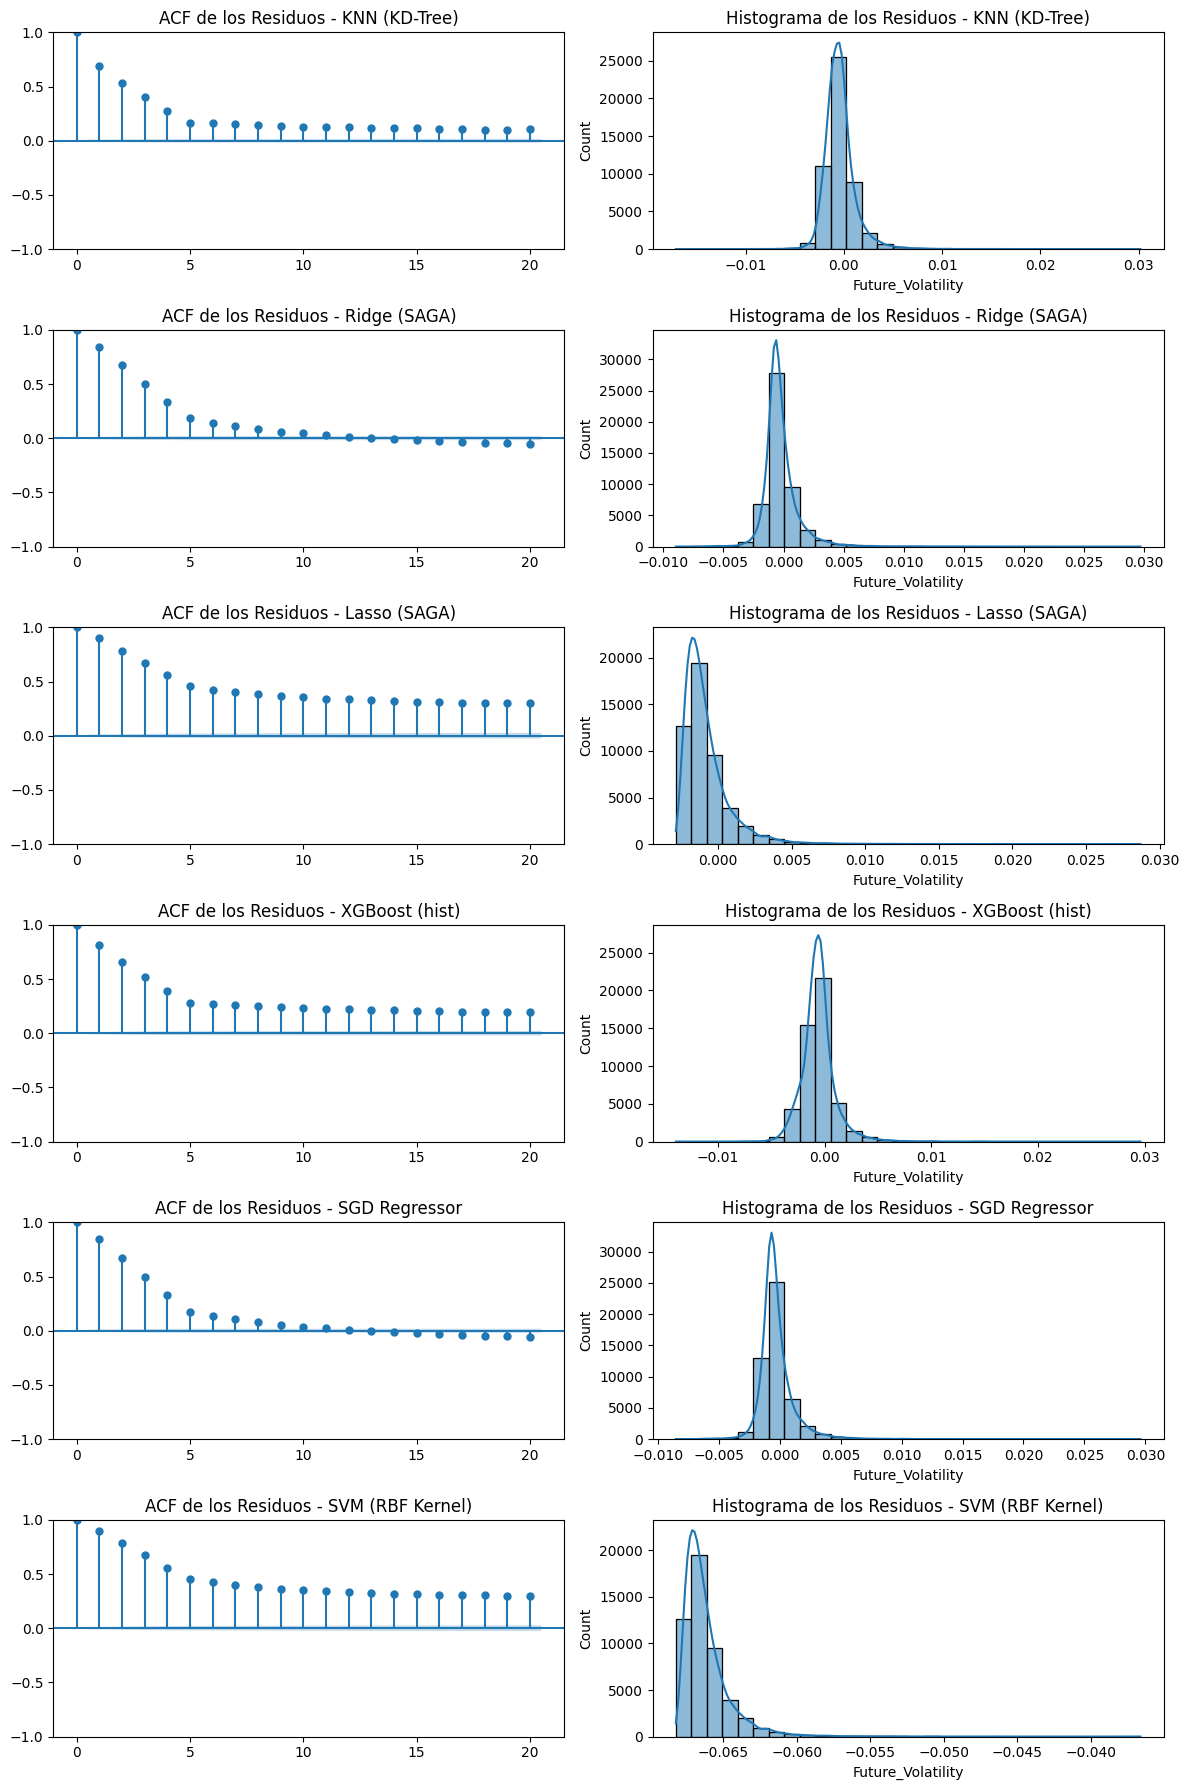

In [63]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Modelos optimizados de regresión
models = {
    "KNN (KD-Tree)": KNeighborsRegressor(algorithm='kd_tree'),
    "Ridge (SAGA)": Ridge(solver='saga'),
    "Lasso (SAGA)": Lasso(),
    "XGBoost (hist)": XGBRegressor(tree_method='hist'),
    "SGD Regressor": SGDRegressor(loss='squared_error', penalty='l2'),
    "SVM (RBF Kernel)": SVR(kernel='rbf')
}

results = []
residuals_dict = {}

for name, model in models.items():
    # Entrenamiento con variables modificadas
    start = time.time()
    model.fit(X_train_vol, y_train_vol)  # Variables ajustadas aquí
    train_time = time.time() - start

    # Predicción con variables modificadas
    start = time.time()
    y_pred = model.predict(X_test_vol)  # Variable ajustada aquí
    pred_time = time.time() - start

    # Cálculo de residuos con variables modificadas
    residuals = y_test_vol - y_pred  # Variable ajustada aquí
    residuals_dict[name] = residuals

    # Métricas con variables modificadas
    mape = mean_absolute_percentage_error(y_test_vol, y_pred)  # Ajustada
    rmse = np.sqrt(mean_squared_error(y_test_vol, y_pred))  # Ajustada
    r2 = r2_score(y_test_vol, y_pred)  # Ajustada

    # Pruebas estadísticas (se mantienen igual)
    ljung_box_p = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].values[0]
    jb_p = jarque_bera(residuals)[1]

    results.append({
        "Modelo": name,
        "Tiempo Entrenamiento": train_time,
        "Tiempo Predicción": pred_time,
        "MAPE": mape,
        "RMSE": rmse,
        "R²": r2,
        "Ljung-Box p-value": ljung_box_p,
        "Jarque-Bera p-value": jb_p
    })

# Resultados comparativos (se mantiene igual)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="R²", ascending=False))

# Gráficos (se mantienen igual)
fig, axes = plt.subplots(len(models), 2, figsize=(12, len(models) * 3))

for i, (name, residuals) in enumerate(residuals_dict.items()):
    plot_acf(residuals, ax=axes[i, 0], lags=20)
    axes[i, 0].set_title(f"ACF de los Residuos - {name}")
    
    sns.histplot(residuals, bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Histograma de los Residuos - {name}")

plt.tight_layout()
plt.show()